# Cluster mappings 

just for getting the clusters ready, which means taking the cluster datetimes and finding the original HYSPLIT trajectories so you can plot everything including all the trajs of the esemble. 

we produce ***Figure 4***: maps of the various clusters

In [4]:
import sys

script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\HYSPLIT_plotting')
import HYSPLIT_plotting as HYplot

sys.path.append(script_path+'\\HYSPLIT-processing')
import HYSPLIT_processing as HYprocess

sys.path.append(script_path+'\\Trends')
import trends_functions as fu_trends

sys.path.append(script_path+'\\clustering_HYSPLIT')
import clustering_functions as fu_cluster

%load_ext autoreload
%autoreload 2

import pandas as pd
import cmocean
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# Check memory, delete if necessary: 

In [5]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, HYplot.sizeof_fmt(size)))

                          tqdm:  1.0 KiB
               NamespaceMagics:  896.0 B
                           _ii:  859.0 B
                           _i3:  859.0 B
                            _i:  674.0 B
                           _i4:  674.0 B
                          _iii:  427.0 B
                           _i2:  427.0 B
                           _i5:  259.0 B
                           _oh:  232.0 B


# Load data: 

In [ ]:
inpath_processed_hysplit_dfs="F:\\HYSPLIT\\processed\\"
cluster_load_path = r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered'

save_path = r'E:\HYSPLIT\processed\Clustering\years_with_clusters'
savepath = r'E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot'

savepath_plots = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

In [12]:
df_abs637 = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended',                   
                       filename='oldpsap_newpsap_maap',)
df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

df_abs637_rain = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)

first_season = fu_trends.get_first_season(df_abs637_rain)        
season_to_season_num = fu_trends.get_full_season_abb_years(start_year=2002, number_years=2024-2002, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

df_abs637_rain = fu_trends.prepare_data(df_abs637_rain, season_num_to_season)

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat
start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


In [8]:
def get_list_files(df_obs, traj_length = 241, year = 2002, 
                   inpath_processed_hysplit_dfs="E:\\Data\\HYSPLIT\\processed\\"):
    list_of_HYSPLIT_files = list_files(year, inpath_processed_hysplit_dfs) 
    HYSPLIT_names = create_HYSPLIT_name_from_list(df_obs.index)
    matching_list_of_back_traj_files = find_matching_files(list_of_HYSPLIT_files,
                                                                  HYSPLIT_names)
    return matching_list_of_back_traj_files

# Load the clusters: 

and create the dictionary that links the arrival time and traj_num and clusters_5

In [14]:
traj_num = 'Traj_num'
df_clusters = HYplot.load_df(cluster_load_path, 
                            filename='df_clusters_5_v2')
print("length of absoprtion data set: "+str(len(df_abs637)))
df_clusters = df_clusters.reset_index()
print("unique number of arrival times: "+str(len(df_clusters['arrival_time'].unique())))
dict_arrival_time_to_df_traj_num_clusters = {k: v[[traj_num,'clusters_5']] for k, v in df_clusters.groupby('arrival_time')}

loading: F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered\df_clusters_5_v2.dat
length of absoprtion data set: 157263
unique number of arrival times: 136162


In [15]:
df_clusters.head(2)

arrival_time  Traj_num  clusters_5
0 2002-03-08 14:00:00         1           5
1 2002-03-08 14:00:00         2           5

# Load and append all the back trajectory information - will need it for the mappings: 

In [6]:
def append_trajs_with_clusters(list_of_files, dict_arrival_time_to_df_traj_num_clusters=None, 
                 usecols=['DateTime','Traj_num','altitude','MIXDEPTH', 'grid_lon', 'grid_lat'],
                traj_length=241, data_format='.dat'):
    appended_ds = []
    for file in tqdm(list_of_files): #the list of HYSPLIT trajs to append/analyse
        if data_format == '.dat':
            ds = pd.read_csv(file, usecols=usecols, parse_dates=True) #read data 
        if data_format == '.pickle':
            ds = pd.read_pickle(file) 
            if ds.index.name == 'DateTime':
                ds = ds.reset_index()
                
        size_of_ensemble = len(ds['Traj_num'].unique())    
        number_of_trajs = len(ds.index.unique())
  
        size_of_ds = len(ds)
        if size_of_ds != 27*241:
            print("not 6 507")
            print(size_of_ds)
            print(file)
        
        arrival_time = pd.to_datetime(ds['DateTime'].iloc[0]) #find arrival time which is the initial time of the traj ds 
        if dict_arrival_time_to_df_traj_num_clusters is not None: #use dictionary to find the clusters
            try:
                df_traj_num_clusters = dict_arrival_time_to_df_traj_num_clusters[arrival_time] #df_cluster for specific trajectory
                dict_traj_to_cluster = dict(zip(df_traj_num_clusters['Traj_num'], df_traj_num_clusters['clusters_5']))
                ds['clusters_5'] = ds['Traj_num'].map(dict_traj_to_cluster)
            except: 
                ds['clusters_5'] = np.nan              
        appended_ds.append(ds)
    ds_all_files = pd.concat(appended_ds)
    return ds_all_files

## process and save - for all years: 

remember we have to do this because the clustering file only had the x,y,z s

In [9]:
for year in np.arange(2009, 2024, 1):
    print("year: "+str(year))
    list_of_files = HYplot.get_list_files(df_obs = df_abs637, traj_length = 241, year = year,
                       inpath_processed_hysplit_dfs=inpath_processed_hysplit_dfs)
    try:
        del ds_all_files
    except:
        pass
    ds_all_files = append_trajs_with_clusters(list_of_files, 
                                              dict_arrival_time_to_df_traj_num_clusters,
                                              data_format='.pickle')
    ds_all_files.to_pickle(save_path+'\\'+str(year)+'.pickle')

year: 2009
Matching files from observational data & HYSPLIT: 7522


 14%|███████████▎                                                                  | 1087/7522 [01:29<08:29, 12.64it/s]

not 6 507
4563
E:\HYSPLIT\processed\2009\20090301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2009\20090301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2009\20090301_02.pickle


 15%|███████████▎                                                                  | 1091/7522 [01:29<08:28, 12.64it/s]

not 6 507
4644
E:\HYSPLIT\processed\2009\20090301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2009\20090301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2009\20090301_05.pickle


 15%|███████████▎                                                                  | 1093/7522 [01:29<08:14, 13.01it/s]

not 6 507
4725
E:\HYSPLIT\processed\2009\20090301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2009\20090301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2009\20090301_08.pickle


 15%|███████████▍                                                                  | 1098/7522 [01:30<07:26, 14.40it/s]

not 6 507
4806
E:\HYSPLIT\processed\2009\20090301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2009\20090301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2009\20090301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2009\20090301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2009\20090301_13.pickle


 15%|███████████▍                                                                  | 1101/7522 [01:30<06:26, 16.61it/s]

not 6 507
4941
E:\HYSPLIT\processed\2009\20090301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2009\20090301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2009\20090301_16.pickle


 15%|███████████▍                                                                  | 1105/7522 [01:30<07:11, 14.88it/s]

not 6 507
5022
E:\HYSPLIT\processed\2009\20090301_17.pickle
not 6 507
5049
E:\HYSPLIT\processed\2009\20090301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2009\20090301_19.pickle


 15%|███████████▍                                                                  | 1109/7522 [01:30<06:51, 15.58it/s]

not 6 507
5103
E:\HYSPLIT\processed\2009\20090301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2009\20090301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2009\20090301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2009\20090301_23.pickle


 15%|███████████▌                                                                  | 1111/7522 [01:30<08:22, 12.76it/s]

not 6 507
5211
E:\HYSPLIT\processed\2009\20090302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2009\20090302_01.pickle


 15%|███████████▌                                                                  | 1113/7522 [01:31<08:46, 12.17it/s]

not 6 507
5265
E:\HYSPLIT\processed\2009\20090302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2009\20090302_03.pickle


 15%|███████████▌                                                                  | 1115/7522 [01:31<09:58, 10.71it/s]

not 6 507
5319
E:\HYSPLIT\processed\2009\20090302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2009\20090302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2009\20090302_06.pickle


 15%|███████████▋                                                                  | 1128/7522 [01:31<03:22, 31.56it/s]

not 6 507
5400
E:\HYSPLIT\processed\2009\20090302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2009\20090302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2009\20090302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2009\20090302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2009\20090302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2009\20090302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2009\20090302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2009\20090302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2009\20090302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2009\20090302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2009\20090302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2009\20090302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2009\20090302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2009\20090302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2009\20090302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2009\20090302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2009

 15%|███████████▊                                                                  | 1142/7522 [01:31<02:30, 42.45it/s]

not 6 507
5859
E:\HYSPLIT\processed\2009\20090303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2009\20090303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2009\20090303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2009\20090303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2009\20090303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2009\20090303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2009\20090303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2009\20090303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2009\20090303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2009\20090303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2009\20090303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2009\20090303_11.pickle


 15%|███████████▉                                                                  | 1147/7522 [01:32<04:39, 22.80it/s]

not 6 507
6183
E:\HYSPLIT\processed\2009\20090303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2009\20090303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2009\20090303_14.pickle
not 6 507
6291
E:\HYSPLIT\processed\2009\20090303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2009\20090303_17.pickle


 15%|███████████▉                                                                  | 1151/7522 [01:32<06:01, 17.64it/s]

not 6 507
6345
E:\HYSPLIT\processed\2009\20090303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2009\20090303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2009\20090303_20.pickle


 15%|███████████▉                                                                  | 1154/7522 [01:32<06:22, 16.66it/s]

not 6 507
6426
E:\HYSPLIT\processed\2009\20090303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2009\20090303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2009\20090303_23.pickle


 27%|█████████████████████▎                                                        | 2060/7522 [02:21<02:10, 41.90it/s]

not 6 507
5859
E:\HYSPLIT\processed\2009\20090501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2009\20090501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2009\20090501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2009\20090501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2009\20090501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2009\20090501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2009\20090501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2009\20090501_07.pickle
not 6 507
6102
E:\HYSPLIT\processed\2009\20090501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2009\20090501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2009\20090501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2009\20090501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2009\20090501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2009\20090501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2009\20090501_15.pickle


 28%|█████████████████████▌                                                        | 2076/7522 [02:21<01:40, 54.03it/s]

not 6 507
6291
E:\HYSPLIT\processed\2009\20090501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2009\20090501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2009\20090501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2009\20090501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2009\20090501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2009\20090501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2009\20090501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2009\20090501_23.pickle


 43%|█████████████████████████████████▊                                            | 3263/7522 [03:35<04:49, 14.70it/s]

not 6 507
5859
E:\HYSPLIT\processed\2009\20090701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2009\20090701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2009\20090701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2009\20090701_03.pickle


 43%|█████████████████████████████████▉                                            | 3267/7522 [03:36<04:40, 15.18it/s]

not 6 507
5967
E:\HYSPLIT\processed\2009\20090701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2009\20090701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2009\20090701_06.pickle


 43%|█████████████████████████████████▉                                            | 3271/7522 [03:36<04:20, 16.31it/s]

not 6 507
6048
E:\HYSPLIT\processed\2009\20090701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2009\20090701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2009\20090701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2009\20090701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2009\20090701_11.pickle


 44%|█████████████████████████████████▉                                            | 3277/7522 [03:36<03:16, 21.66it/s]

not 6 507
6183
E:\HYSPLIT\processed\2009\20090701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2009\20090701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2009\20090701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2009\20090701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2009\20090701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2009\20090701_17.pickle


 44%|██████████████████████████████████                                            | 3280/7522 [03:36<03:19, 21.23it/s]

not 6 507
6345
E:\HYSPLIT\processed\2009\20090701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2009\20090701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2009\20090701_20.pickle


 44%|██████████████████████████████████                                            | 3283/7522 [03:36<03:57, 17.88it/s]

not 6 507
6426
E:\HYSPLIT\processed\2009\20090701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2009\20090701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2009\20090701_23.pickle


 72%|████████████████████████████████████████████████████████▍                     | 5447/7522 [05:37<02:51, 12.08it/s]

not 6 507
5859
E:\HYSPLIT\processed\2009\20091001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2009\20091001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2009\20091001_02.pickle


 72%|████████████████████████████████████████████████████████▌                     | 5451/7522 [05:38<02:49, 12.25it/s]

not 6 507
5940
E:\HYSPLIT\processed\2009\20091001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2009\20091001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2009\20091001_05.pickle


 72%|████████████████████████████████████████████████████████▌                     | 5453/7522 [05:38<02:53, 11.93it/s]

not 6 507
6021
E:\HYSPLIT\processed\2009\20091001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2009\20091001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2009\20091001_08.pickle


 73%|████████████████████████████████████████████████████████▌                     | 5457/7522 [05:38<02:43, 12.61it/s]

not 6 507
6102
E:\HYSPLIT\processed\2009\20091001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2009\20091001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2009\20091001_11.pickle


 73%|████████████████████████████████████████████████████████▌                     | 5459/7522 [05:38<02:44, 12.56it/s]

not 6 507
6183
E:\HYSPLIT\processed\2009\20091001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2009\20091001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2009\20091001_14.pickle


 73%|████████████████████████████████████████████████████████▋                     | 5463/7522 [05:39<03:17, 10.45it/s]

not 6 507
6264
E:\HYSPLIT\processed\2009\20091001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2009\20091001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2009\20091001_17.pickle


 73%|████████████████████████████████████████████████████████▋                     | 5465/7522 [05:39<02:57, 11.58it/s]

not 6 507
6345
E:\HYSPLIT\processed\2009\20091001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2009\20091001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2009\20091001_20.pickle


 73%|████████████████████████████████████████████████████████▋                     | 5469/7522 [05:39<02:34, 13.29it/s]

not 6 507
6426
E:\HYSPLIT\processed\2009\20091001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2009\20091001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2009\20091001_23.pickle


 86%|███████████████████████████████████████████████████████████████████▍          | 6506/7522 [06:40<00:36, 28.16it/s]

not 6 507
6291
E:\HYSPLIT\processed\2009\20091201_16.pickle


 87%|███████████████████████████████████████████████████████████████████▋          | 6527/7522 [06:42<01:15, 13.15it/s]

not 6 507
6210
E:\HYSPLIT\processed\2009\20091201_13.pickle


 87%|███████████████████████████████████████████████████████████████████▉          | 6551/7522 [06:43<00:37, 26.06it/s]

not 6 507
6318
E:\HYSPLIT\processed\2009\20091201_17.pickle


 87%|███████████████████████████████████████████████████████████████████▉          | 6557/7522 [06:43<00:45, 20.98it/s]

not 6 507
6021
E:\HYSPLIT\processed\2009\20091201_06.pickle


 87%|████████████████████████████████████████████████████████████████████▏         | 6570/7522 [06:44<00:49, 19.21it/s]

not 6 507
6048
E:\HYSPLIT\processed\2009\20091201_07.pickle


 88%|████████████████████████████████████████████████████████████████████▋         | 6618/7522 [06:46<00:44, 20.09it/s]

not 6 507
5994
E:\HYSPLIT\processed\2009\20091201_05.pickle


 88%|████████████████████████████████████████████████████████████████████▊         | 6631/7522 [06:47<00:38, 22.91it/s]

not 6 507
6183
E:\HYSPLIT\processed\2009\20091201_12.pickle


 88%|█████████████████████████████████████████████████████████████████████         | 6656/7522 [06:48<00:43, 20.04it/s]

not 6 507
5940
E:\HYSPLIT\processed\2009\20091201_03.pickle


 89%|█████████████████████████████████████████████████████████████████████▎        | 6686/7522 [06:50<01:06, 12.53it/s]

not 6 507
5886
E:\HYSPLIT\processed\2009\20091201_01.pickle


 89%|█████████████████████████████████████████████████████████████████████▎        | 6690/7522 [06:51<01:05, 12.63it/s]

not 6 507
6264
E:\HYSPLIT\processed\2009\20091201_15.pickle


 89%|█████████████████████████████████████████████████████████████████████▌        | 6713/7522 [06:52<00:35, 22.88it/s]

not 6 507
6426
E:\HYSPLIT\processed\2009\20091201_21.pickle


 92%|███████████████████████████████████████████████████████████████████████▍      | 6884/7522 [07:02<00:41, 15.28it/s]

not 6 507
6453
E:\HYSPLIT\processed\2009\20091201_22.pickle
not 6 507
5967
E:\HYSPLIT\processed\2009\20091201_04.pickle


 92%|███████████████████████████████████████████████████████████████████████▌      | 6904/7522 [07:04<00:36, 16.88it/s]

not 6 507
6075
E:\HYSPLIT\processed\2009\20091201_08.pickle


 92%|███████████████████████████████████████████████████████████████████████▉      | 6941/7522 [07:06<00:44, 13.04it/s]

not 6 507
6156
E:\HYSPLIT\processed\2009\20091201_11.pickle


 93%|████████████████████████████████████████████████████████████████████████▎     | 6972/7522 [07:08<00:20, 27.29it/s]

not 6 507
5859
E:\HYSPLIT\processed\2009\20091201_00.pickle


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7168/7522 [07:20<00:15, 22.42it/s]

not 6 507
6372
E:\HYSPLIT\processed\2009\20091201_19.pickle


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7194/7522 [07:22<00:17, 18.39it/s]

not 6 507
6480
E:\HYSPLIT\processed\2009\20091201_23.pickle


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7215/7522 [07:23<00:11, 25.73it/s]

not 6 507
5913
E:\HYSPLIT\processed\2009\20091201_02.pickle


 96%|███████████████████████████████████████████████████████████████████████████   | 7243/7522 [07:24<00:12, 21.52it/s]

not 6 507
6399
E:\HYSPLIT\processed\2009\20091201_20.pickle


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7388/7522 [07:31<00:07, 17.23it/s]

not 6 507
6345
E:\HYSPLIT\processed\2009\20091201_18.pickle


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7417/7522 [07:33<00:06, 17.48it/s]

not 6 507
6129
E:\HYSPLIT\processed\2009\20091201_10.pickle


100%|█████████████████████████████████████████████████████████████████████████████▊| 7499/7522 [07:39<00:01, 12.59it/s]

not 6 507
6237
E:\HYSPLIT\processed\2009\20091201_14.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 7522/7522 [07:40<00:00, 16.33it/s]

not 6 507
6476
E:\HYSPLIT\processed\2009\20091218_07.pickle


year: 2010
Matching files from observational data & HYSPLIT: 7354


 18%|█████████████▋                                                                | 1290/7354 [01:21<09:09, 11.03it/s]

not 6 507
5535
E:\HYSPLIT\processed\2010\20100302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2010\20100302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2010\20100302_14.pickle


 18%|█████████████▋                                                                | 1292/7354 [01:21<08:59, 11.24it/s]

not 6 507
5616
E:\HYSPLIT\processed\2010\20100302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2010\20100302_16.pickle


 18%|█████████████▋                                                                | 1296/7354 [01:22<09:33, 10.56it/s]

not 6 507
5670
E:\HYSPLIT\processed\2010\20100302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2010\20100302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2010\20100302_19.pickle


 18%|█████████████▊                                                                | 1300/7354 [01:22<07:39, 13.19it/s]

not 6 507
5751
E:\HYSPLIT\processed\2010\20100302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2010\20100302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2010\20100302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2010\20100302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2010\20100303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2010\20100303_01.pickle


 18%|█████████████▊                                                                | 1305/7354 [01:22<06:15, 16.11it/s]

not 6 507
5913
E:\HYSPLIT\processed\2010\20100303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2010\20100303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2010\20100303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2010\20100303_05.pickle


 18%|█████████████▉                                                                | 1309/7354 [01:23<07:27, 13.51it/s]

not 6 507
6021
E:\HYSPLIT\processed\2010\20100303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2010\20100303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2010\20100303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2010\20100303_09.pickle


 18%|█████████████▉                                                                | 1314/7354 [01:23<06:16, 16.04it/s]

not 6 507
6129
E:\HYSPLIT\processed\2010\20100303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2010\20100303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2010\20100303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2010\20100303_13.pickle


 18%|██████████████                                                                | 1324/7354 [01:23<03:14, 31.08it/s]

not 6 507
6237
E:\HYSPLIT\processed\2010\20100303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2010\20100303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2010\20100303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2010\20100303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2010\20100303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2010\20100303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2010\20100303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2010\20100303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2010\20100303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2010\20100303_23.pickle


 28%|█████████████████████▉                                                        | 2066/7354 [02:09<04:06, 21.45it/s]

not 6 507
5859
E:\HYSPLIT\processed\2010\20100501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2010\20100501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2010\20100501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2010\20100501_03.pickle


 28%|█████████████████████▉                                                        | 2072/7354 [02:09<03:41, 23.88it/s]

not 6 507
5967
E:\HYSPLIT\processed\2010\20100501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2010\20100501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2010\20100501_06.pickle


 28%|██████████████████████                                                        | 2075/7354 [02:09<04:14, 20.73it/s]

not 6 507
6048
E:\HYSPLIT\processed\2010\20100501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2010\20100501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2010\20100501_09.pickle


 28%|██████████████████████▏                                                       | 2086/7354 [02:10<03:09, 27.74it/s]

not 6 507
6129
E:\HYSPLIT\processed\2010\20100501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2010\20100501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2010\20100501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2010\20100501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2010\20100501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2010\20100501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2010\20100501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2010\20100501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2010\20100501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2010\20100501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2010\20100501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2010\20100501_21.pickle


 28%|██████████████████████▏                                                       | 2093/7354 [02:10<04:37, 18.95it/s]

not 6 507
6453
E:\HYSPLIT\processed\2010\20100501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2010\20100501_23.pickle


 44%|██████████████████████████████████▌                                           | 3263/7354 [03:19<03:09, 21.60it/s]

not 6 507
5859
E:\HYSPLIT\processed\2010\20100701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2010\20100701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2010\20100701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2010\20100701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2010\20100701_04.pickle


 44%|██████████████████████████████████▋                                           | 3266/7354 [03:19<03:09, 21.56it/s]

not 6 507
5994
E:\HYSPLIT\processed\2010\20100701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2010\20100701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2010\20100701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2010\20100701_08.pickle


 44%|██████████████████████████████████▋                                           | 3269/7354 [03:19<03:38, 18.72it/s]

not 6 507
6102
E:\HYSPLIT\processed\2010\20100701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2010\20100701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2010\20100701_11.pickle


 45%|██████████████████████████████████▋                                           | 3273/7354 [03:20<04:27, 15.26it/s]

not 6 507
6183
E:\HYSPLIT\processed\2010\20100701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2010\20100701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2010\20100701_14.pickle


 45%|██████████████████████████████████▋                                           | 3275/7354 [03:20<04:41, 14.48it/s]

not 6 507
6264
E:\HYSPLIT\processed\2010\20100701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2010\20100701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2010\20100701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2010\20100701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2010\20100701_19.pickle


 45%|██████████████████████████████████▊                                           | 3282/7354 [03:20<03:46, 18.00it/s]

not 6 507
6399
E:\HYSPLIT\processed\2010\20100701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2010\20100701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2010\20100701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2010\20100701_23.pickle


 62%|████████████████████████████████████████████████                              | 4535/7354 [04:41<02:24, 19.47it/s]

not 6 507
5859
E:\HYSPLIT\processed\2010\20101001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2010\20101001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2010\20101001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2010\20101001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2010\20101001_04.pickle


 62%|████████████████████████████████████████████████▏                             | 4538/7354 [04:42<03:07, 15.00it/s]

not 6 507
5994
E:\HYSPLIT\processed\2010\20101001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2010\20101001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2010\20101001_07.pickle


 62%|████████████████████████████████████████████████▏                             | 4540/7354 [04:42<03:20, 14.04it/s]

not 6 507
6075
E:\HYSPLIT\processed\2010\20101001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2010\20101001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2010\20101001_10.pickle


 62%|████████████████████████████████████████████████▏                             | 4542/7354 [04:42<03:45, 12.49it/s]

not 6 507
6156
E:\HYSPLIT\processed\2010\20101001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2010\20101001_12.pickle


 62%|████████████████████████████████████████████████▏                             | 4546/7354 [04:43<03:56, 11.87it/s]

not 6 507
6210
E:\HYSPLIT\processed\2010\20101001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2010\20101001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2010\20101001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2010\20101001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2010\20101001_17.pickle


 62%|████████████████████████████████████████████████▎                             | 4553/7354 [04:43<02:34, 18.18it/s]

not 6 507
6345
E:\HYSPLIT\processed\2010\20101001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2010\20101001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2010\20101001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2010\20101001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2010\20101001_22.pickle


 62%|████████████████████████████████████████████████▎                             | 4558/7354 [04:43<02:06, 22.10it/s]

not 6 507
6480
E:\HYSPLIT\processed\2010\20101001_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 7354/7354 [07:09<00:00, 17.13it/s]


year: 2011
Matching files from observational data & HYSPLIT: 7124


 19%|███████████████▏                                                              | 1386/7124 [01:46<07:51, 12.17it/s]

not 6 507
4563
E:\HYSPLIT\processed\2011\20110301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2011\20110301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2011\20110301_02.pickle


 20%|███████████████▏                                                              | 1390/7124 [01:46<08:21, 11.43it/s]

not 6 507
4644
E:\HYSPLIT\processed\2011\20110301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2011\20110301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2011\20110301_05.pickle


 20%|███████████████▎                                                              | 1396/7124 [01:46<06:03, 15.75it/s]

not 6 507
4725
E:\HYSPLIT\processed\2011\20110301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2011\20110301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2011\20110301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2011\20110301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2011\20110301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2011\20110301_11.pickle


 20%|███████████████▎                                                              | 1398/7124 [01:47<06:13, 15.34it/s]

not 6 507
4887
E:\HYSPLIT\processed\2011\20110301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2011\20110301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2011\20110301_14.pickle


 20%|███████████████▎                                                              | 1402/7124 [01:47<06:41, 14.26it/s]

not 6 507
4968
E:\HYSPLIT\processed\2011\20110301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2011\20110301_16.pickle
not 6 507
5022
E:\HYSPLIT\processed\2011\20110301_17.pickle
not 6 507
5049
E:\HYSPLIT\processed\2011\20110301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2011\20110301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2011\20110301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2011\20110301_21.pickle
not 6 507
5157

 20%|███████████████▍                                                              | 1408/7124 [01:47<04:06, 23.17it/s]


E:\HYSPLIT\processed\2011\20110301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2011\20110301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2011\20110302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2011\20110302_01.pickle


 20%|███████████████▍                                                              | 1411/7124 [01:47<04:36, 20.67it/s]

not 6 507
5265
E:\HYSPLIT\processed\2011\20110302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2011\20110302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2011\20110302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2011\20110302_05.pickle


 20%|███████████████▌                                                              | 1416/7124 [01:48<05:40, 16.77it/s]

not 6 507
5373
E:\HYSPLIT\processed\2011\20110302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2011\20110302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2011\20110302_08.pickle


 20%|███████████████▌                                                              | 1420/7124 [01:48<07:23, 12.86it/s]

not 6 507
5454
E:\HYSPLIT\processed\2011\20110302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2011\20110302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2011\20110302_11.pickle


 20%|███████████████▌                                                              | 1422/7124 [01:48<08:34, 11.09it/s]

not 6 507
5535
E:\HYSPLIT\processed\2011\20110302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2011\20110302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2011\20110302_14.pickle


 20%|███████████████▌                                                              | 1426/7124 [01:49<07:24, 12.82it/s]

not 6 507
5616
E:\HYSPLIT\processed\2011\20110302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2011\20110302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2011\20110302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2011\20110302_18.pickle


 20%|███████████████▋                                                              | 1430/7124 [01:49<07:17, 13.00it/s]

not 6 507
5724
E:\HYSPLIT\processed\2011\20110302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2011\20110302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2011\20110302_21.pickle


 20%|███████████████▋                                                              | 1432/7124 [01:49<07:46, 12.21it/s]

not 6 507
5805
E:\HYSPLIT\processed\2011\20110302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2011\20110302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2011\20110303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2011\20110303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2011\20110303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2011\20110303_03.pickle


 20%|███████████████▊                                                              | 1441/7124 [01:49<04:53, 19.38it/s]

not 6 507
5967
E:\HYSPLIT\processed\2011\20110303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2011\20110303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2011\20110303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2011\20110303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2011\20110303_08.pickle


 20%|███████████████▊                                                              | 1444/7124 [01:50<05:29, 17.26it/s]

not 6 507
6102
E:\HYSPLIT\processed\2011\20110303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2011\20110303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2011\20110303_11.pickle


 20%|███████████████▊                                                              | 1446/7124 [01:50<06:18, 14.99it/s]

not 6 507
6183
E:\HYSPLIT\processed\2011\20110303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2011\20110303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2011\20110303_14.pickle


 20%|███████████████▉                                                              | 1450/7124 [01:50<06:38, 14.24it/s]

not 6 507
6264
E:\HYSPLIT\processed\2011\20110303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2011\20110303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2011\20110303_17.pickle


 20%|███████████████▉                                                              | 1452/7124 [01:50<06:29, 14.56it/s]

not 6 507
6345
E:\HYSPLIT\processed\2011\20110303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2011\20110303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2011\20110303_20.pickle


 20%|███████████████▉                                                              | 1456/7124 [01:51<06:54, 13.68it/s]

not 6 507
6426
E:\HYSPLIT\processed\2011\20110303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2011\20110303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2011\20110303_23.pickle


 42%|████████████████████████████████▍                                             | 2963/7124 [03:35<03:21, 20.63it/s]

not 6 507
5859
E:\HYSPLIT\processed\2011\20110701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2011\20110701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2011\20110701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2011\20110701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2011\20110701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2011\20110701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2011\20110701_06.pickle


 42%|████████████████████████████████▌                                             | 2969/7124 [03:35<03:00, 23.03it/s]

not 6 507
6048
E:\HYSPLIT\processed\2011\20110701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2011\20110701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2011\20110701_09.pickle


 42%|████████████████████████████████▌                                             | 2979/7124 [03:36<02:24, 28.71it/s]

not 6 507
6129
E:\HYSPLIT\processed\2011\20110701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2011\20110701_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2011\20110701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2011\20110701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2011\20110701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2011\20110701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2011\20110701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2011\20110701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2011\20110701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2011\20110701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2011\20110701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2011\20110701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2011\20110701_22.pickle


 42%|████████████████████████████████▋                                             | 2991/7124 [03:36<01:54, 36.06it/s]

not 6 507
6480
E:\HYSPLIT\processed\2011\20110701_23.pickle


 51%|████████████████████████████████████████                                      | 3664/7124 [04:17<02:56, 19.62it/s]

not 6 507
6102
E:\HYSPLIT\processed\2011\20111001_09.pickle


 52%|████████████████████████████████████████▍                                     | 3690/7124 [04:19<03:42, 15.46it/s]

not 6 507
5967
E:\HYSPLIT\processed\2011\20111001_04.pickle


 57%|████████████████████████████████████████████▎                                 | 4045/7124 [04:43<03:46, 13.59it/s]

not 6 507
6372
E:\HYSPLIT\processed\2011\20111001_19.pickle


 59%|██████████████████████████████████████████████▏                               | 4217/7124 [04:57<03:39, 13.23it/s]

not 6 507
6426
E:\HYSPLIT\processed\2011\20111201_21.pickle


 59%|██████████████████████████████████████████████▍                               | 4237/7124 [04:58<03:22, 14.28it/s]

not 6 507
6075
E:\HYSPLIT\processed\2011\20111001_08.pickle


 60%|██████████████████████████████████████████████▍                               | 4239/7124 [04:58<03:17, 14.57it/s]

not 6 507
6183
E:\HYSPLIT\processed\2011\20111001_12.pickle


 62%|████████████████████████████████████████████████▋                             | 4446/7124 [05:11<03:04, 14.51it/s]

not 6 507
5886
E:\HYSPLIT\processed\2011\20111001_01.pickle


 64%|██████████████████████████████████████████████████▏                           | 4587/7124 [05:20<03:04, 13.73it/s]

not 6 507
6048
E:\HYSPLIT\processed\2011\20111001_07.pickle


 65%|██████████████████████████████████████████████████▋                           | 4630/7124 [05:23<03:09, 13.15it/s]

not 6 507
6129
E:\HYSPLIT\processed\2011\20111001_10.pickle


 66%|███████████████████████████████████████████████████▊                          | 4737/7124 [05:30<01:42, 23.34it/s]

not 6 507
6399
E:\HYSPLIT\processed\2011\20111201_20.pickle


 67%|████████████████████████████████████████████████████▏                         | 4769/7124 [05:31<02:00, 19.62it/s]

not 6 507
5913
E:\HYSPLIT\processed\2011\20111001_02.pickle


 68%|████████████████████████████████████████████████████▉                         | 4833/7124 [05:36<02:24, 15.86it/s]

not 6 507
6426
E:\HYSPLIT\processed\2011\20111001_21.pickle


 68%|█████████████████████████████████████████████████████                         | 4844/7124 [05:36<02:36, 14.55it/s]

not 6 507
5940
E:\HYSPLIT\processed\2011\20111001_03.pickle


 69%|█████████████████████████████████████████████████████▋                        | 4903/7124 [05:40<01:59, 18.64it/s]

not 6 507
6453
E:\HYSPLIT\processed\2011\20111201_22.pickle


 69%|█████████████████████████████████████████████████████▉                        | 4927/7124 [05:41<02:02, 17.93it/s]

not 6 507
5859
E:\HYSPLIT\processed\2011\20111001_00.pickle


 70%|██████████████████████████████████████████████████████▍                       | 4968/7124 [05:44<02:29, 14.41it/s]

not 6 507
6237
E:\HYSPLIT\processed\2011\20111001_14.pickle


 78%|████████████████████████████████████████████████████████████▋                 | 5545/7124 [06:21<01:37, 16.15it/s]

not 6 507
5994
E:\HYSPLIT\processed\2011\20111001_05.pickle


 82%|███████████████████████████████████████████████████████████████▉              | 5839/7124 [06:39<01:44, 12.29it/s]

not 6 507
6318
E:\HYSPLIT\processed\2011\20111001_17.pickle


 82%|████████████████████████████████████████████████████████████████              | 5847/7124 [06:39<01:44, 12.23it/s]

not 6 507
6480
E:\HYSPLIT\processed\2011\20111201_23.pickle


 84%|█████████████████████████████████████████████████████████████████▋            | 5995/7124 [06:50<01:50, 10.21it/s]

not 6 507
6021
E:\HYSPLIT\processed\2011\20111001_06.pickle


 85%|██████████████████████████████████████████████████████████████████            | 6038/7124 [06:54<01:16, 14.26it/s]

not 6 507
6264
E:\HYSPLIT\processed\2011\20111001_15.pickle


 90%|██████████████████████████████████████████████████████████████████████▍       | 6430/7124 [07:32<01:08, 10.20it/s]

not 6 507
6291
E:\HYSPLIT\processed\2011\20111001_16.pickle


 94%|█████████████████████████████████████████████████████████████████████████     | 6677/7124 [07:58<00:42, 10.52it/s]

not 6 507
6210
E:\HYSPLIT\processed\2011\20111001_13.pickle


 95%|██████████████████████████████████████████████████████████████████████████    | 6765/7124 [08:07<00:34, 10.32it/s]

not 6 507
6156
E:\HYSPLIT\processed\2011\20111001_11.pickle


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6787/7124 [08:09<00:46,  7.32it/s]

not 6 507
6399
E:\HYSPLIT\processed\2011\20111001_20.pickle


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6906/7124 [08:22<00:20, 10.50it/s]

not 6 507
6453
E:\HYSPLIT\processed\2011\20111001_22.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 7124/7124 [08:45<00:00, 13.55it/s]


year: 2012
Matching files from observational data & HYSPLIT: 7723


  0%|▎                                                                               | 30/7723 [00:02<05:37, 22.82it/s]

not 6 507
4104
E:\HYSPLIT\processed\2012\20120212_07.pickle
not 6 507
738
E:\HYSPLIT\processed\2012\20120213_07.pickle
not 6 507
60
E:\HYSPLIT\processed\2012\20120214_07.pickle
not 6 507
60
E:\HYSPLIT\processed\2012\20120215_07.pickle
not 6 507
60
E:\HYSPLIT\processed\2012\20120216_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120217_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120218_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120219_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120220_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120221_07.pickle


  0%|▍                                                                               | 37/7723 [00:02<04:56, 25.91it/s]

not 6 507
36
E:\HYSPLIT\processed\2012\20120222_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120223_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120224_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120225_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120228_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120229_07.pickle


  1%|▍                                                                               | 43/7723 [00:02<04:54, 26.08it/s]

not 6 507
36
E:\HYSPLIT\processed\2012\20120202_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120203_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120204_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120205_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120206_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120207_18.pickle


  1%|█                                                                             | 101/7723 [00:02<00:50, 151.69it/s]

not 6 507
36
E:\HYSPLIT\processed\2012\20120208_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120209_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120210_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120211_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120212_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120213_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120214_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120215_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120216_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120217_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120219_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120220_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120221_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120222_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120223_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120224_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120225_18.pickle
not 6 507
36
E

  2%|█▎                                                                            | 124/7723 [00:02<00:46, 161.69it/s]

not 6 507
36
E:\HYSPLIT\processed\2012\20120219_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120220_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120221_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120222_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120223_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120224_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120225_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120227_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120228_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120229_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120202_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120203_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120204_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120205_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120206_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120207_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120208_15.pickle
not 6 507
36
E

  2%|█▊                                                                            | 180/7723 [00:03<01:06, 113.02it/s]

not 6 507
36
E:\HYSPLIT\processed\2012\20120229_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120202_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120203_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120204_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120205_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120206_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120207_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120208_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120209_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120210_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120211_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120212_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120213_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120214_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120215_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120216_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2012\20120217_23.pickle
not 6 507
36
E

 12%|█████████▍                                                                     | 927/7723 [00:55<06:54, 16.38it/s]

not 6 507
5211
E:\HYSPLIT\processed\2012\20120301_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2012\20120301_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2012\20120301_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2012\20120301_03.pickle


 12%|█████████▌                                                                     | 931/7723 [00:56<08:47, 12.88it/s]

not 6 507
5319
E:\HYSPLIT\processed\2012\20120301_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2012\20120301_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2012\20120301_06.pickle


 12%|█████████▌                                                                     | 935/7723 [00:56<08:15, 13.70it/s]

not 6 507
5400
E:\HYSPLIT\processed\2012\20120301_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2012\20120301_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2012\20120301_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2012\20120301_10.pickle


 12%|█████████▌                                                                     | 938/7723 [00:56<07:37, 14.84it/s]

not 6 507
5508
E:\HYSPLIT\processed\2012\20120301_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2012\20120301_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2012\20120301_13.pickle


 12%|█████████▌                                                                     | 940/7723 [00:56<08:14, 13.72it/s]

not 6 507
5589
E:\HYSPLIT\processed\2012\20120301_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2012\20120301_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2012\20120301_16.pickle


 12%|█████████▋                                                                     | 942/7723 [00:57<09:05, 12.44it/s]

not 6 507
5670
E:\HYSPLIT\processed\2012\20120301_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2012\20120301_18.pickle


 12%|█████████▋                                                                     | 946/7723 [00:57<09:59, 11.30it/s]

not 6 507
5724
E:\HYSPLIT\processed\2012\20120301_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2012\20120301_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2012\20120301_21.pickle


 12%|█████████▋                                                                     | 948/7723 [00:57<10:32, 10.71it/s]

not 6 507
5805
E:\HYSPLIT\processed\2012\20120301_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2012\20120301_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2012\20120302_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2012\20120302_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2012\20120302_02.pickle


 12%|█████████▊                                                                     | 955/7723 [00:57<06:39, 16.94it/s]

not 6 507
5940
E:\HYSPLIT\processed\2012\20120302_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2012\20120302_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2012\20120302_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2012\20120302_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2012\20120302_07.pickle


 12%|█████████▊                                                                     | 960/7723 [00:58<04:57, 22.72it/s]

not 6 507
6075
E:\HYSPLIT\processed\2012\20120302_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2012\20120302_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2012\20120302_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2012\20120302_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2012\20120302_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2012\20120302_13.pickle


 12%|█████████▊                                                                     | 963/7723 [00:58<05:40, 19.84it/s]

not 6 507
6237
E:\HYSPLIT\processed\2012\20120302_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2012\20120302_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2012\20120302_16.pickle


 13%|█████████▉                                                                     | 968/7723 [00:58<07:04, 15.92it/s]

not 6 507
6318
E:\HYSPLIT\processed\2012\20120302_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2012\20120302_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2012\20120302_19.pickle


 13%|█████████▉                                                                     | 970/7723 [00:58<07:43, 14.57it/s]

not 6 507
6399
E:\HYSPLIT\processed\2012\20120302_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2012\20120302_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2012\20120302_22.pickle


 13%|█████████▉                                                                     | 974/7723 [00:59<07:40, 14.64it/s]

not 6 507
6480
E:\HYSPLIT\processed\2012\20120302_23.pickle


 14%|██████████▋                                                                   | 1055/7723 [01:04<05:14, 21.21it/s]

not 6 507
6502
E:\HYSPLIT\processed\2012\20120306_08.pickle


 22%|████████████████▊                                                             | 1668/7723 [01:47<08:37, 11.71it/s]

not 6 507
5859
E:\HYSPLIT\processed\2012\20120501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2012\20120501_01.pickle


 22%|████████████████▊                                                             | 1670/7723 [01:47<09:12, 10.96it/s]

not 6 507
5913
E:\HYSPLIT\processed\2012\20120501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2012\20120501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2012\20120501_04.pickle


 22%|████████████████▉                                                             | 1674/7723 [01:48<09:17, 10.84it/s]

not 6 507
5994
E:\HYSPLIT\processed\2012\20120501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2012\20120501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2012\20120501_07.pickle


 22%|████████████████▉                                                             | 1678/7723 [01:48<08:44, 11.53it/s]

not 6 507
6075
E:\HYSPLIT\processed\2012\20120501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2012\20120501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2012\20120501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2012\20120501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2012\20120501_12.pickle


 22%|████████████████▉                                                             | 1683/7723 [01:48<07:10, 14.04it/s]

not 6 507
6210
E:\HYSPLIT\processed\2012\20120501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2012\20120501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2012\20120501_15.pickle


 22%|█████████████████                                                             | 1685/7723 [01:48<06:51, 14.69it/s]

not 6 507
6291
E:\HYSPLIT\processed\2012\20120501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2012\20120501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2012\20120501_18.pickle


 22%|█████████████████                                                             | 1690/7723 [01:49<06:02, 16.65it/s]

not 6 507
6372
E:\HYSPLIT\processed\2012\20120501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2012\20120501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2012\20120501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2012\20120501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2012\20120501_23.pickle


 30%|███████████████████████▏                                                      | 2291/7723 [02:32<06:16, 14.42it/s]

not 6 507
5859
E:\HYSPLIT\processed\2012\20120701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2012\20120701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2012\20120701_02.pickle


 30%|███████████████████████▏                                                      | 2293/7723 [02:32<06:17, 14.38it/s]

not 6 507
5940
E:\HYSPLIT\processed\2012\20120701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2012\20120701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2012\20120701_05.pickle


 30%|███████████████████████▏                                                      | 2297/7723 [02:33<07:34, 11.93it/s]

not 6 507
6021
E:\HYSPLIT\processed\2012\20120701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2012\20120701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2012\20120701_08.pickle


 30%|███████████████████████▏                                                      | 2299/7723 [02:33<06:48, 13.27it/s]

not 6 507
6102
E:\HYSPLIT\processed\2012\20120701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2012\20120701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2012\20120701_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2012\20120701_12.pickle


 30%|███████████████████████▎                                                      | 2305/7723 [02:33<05:13, 17.30it/s]

not 6 507
6210
E:\HYSPLIT\processed\2012\20120701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2012\20120701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2012\20120701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2012\20120701_16.pickle


 30%|███████████████████████▎                                                      | 2307/7723 [02:33<06:24, 14.09it/s]

not 6 507
6318
E:\HYSPLIT\processed\2012\20120701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2012\20120701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2012\20120701_19.pickle


 30%|███████████████████████▎                                                      | 2309/7723 [02:33<06:58, 12.93it/s]

not 6 507
6399
E:\HYSPLIT\processed\2012\20120701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2012\20120701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2012\20120701_22.pickle


 30%|███████████████████████▍                                                      | 2320/7723 [02:34<04:00, 22.42it/s]

not 6 507
6480
E:\HYSPLIT\processed\2012\20120701_23.pickle


 35%|███████████████████████████▎                                                  | 2704/7723 [03:00<05:06, 16.36it/s]

not 6 507
6345
E:\HYSPLIT\processed\2012\20121001_18.pickle
not 6 507
6480
E:\HYSPLIT\processed\2012\20121001_23.pickle


 36%|███████████████████████████▉                                                  | 2764/7723 [03:04<06:34, 12.58it/s]

not 6 507
5967
E:\HYSPLIT\processed\2012\20121001_04.pickle


 36%|███████████████████████████▉                                                  | 2770/7723 [03:04<06:50, 12.05it/s]

not 6 507
5994
E:\HYSPLIT\processed\2012\20121201_05.pickle


 37%|████████████████████████████▊                                                 | 2858/7723 [03:10<04:59, 16.22it/s]

not 6 507
6075
E:\HYSPLIT\processed\2012\20121001_08.pickle


 37%|████████████████████████████▉                                                 | 2865/7723 [03:10<03:39, 22.15it/s]

not 6 507
6503
E:\HYSPLIT\processed\2012\20120916_16.pickle


 37%|████████████████████████████▉                                                 | 2868/7723 [03:11<03:56, 20.54it/s]

not 6 507
6156
E:\HYSPLIT\processed\2012\20121201_11.pickle


 40%|███████████████████████████████▍                                              | 3109/7723 [03:25<02:29, 30.81it/s]

not 6 507
6452
E:\HYSPLIT\processed\2012\20121016_16.pickle


 41%|███████████████████████████████▋                                              | 3133/7723 [03:26<03:49, 19.99it/s]

not 6 507
6426
E:\HYSPLIT\processed\2012\20121001_21.pickle


 41%|████████████████████████████████                                              | 3170/7723 [03:29<06:27, 11.74it/s]

not 6 507
5859
E:\HYSPLIT\processed\2012\20121001_00.pickle


 47%|████████████████████████████████████▊                                         | 3650/7723 [04:04<05:20, 12.71it/s]

not 6 507
6504
E:\HYSPLIT\processed\2012\20121012_11.pickle


 51%|███████████████████████████████████████▍                                      | 3902/7723 [04:21<03:13, 19.75it/s]

not 6 507
5886
E:\HYSPLIT\processed\2012\20121001_01.pickle


 57%|████████████████████████████████████████████▎                                 | 4386/7723 [04:48<02:24, 23.17it/s]

not 6 507
5940
E:\HYSPLIT\processed\2012\20121201_03.pickle


 57%|████████████████████████████████████████████▋                                 | 4426/7723 [04:50<03:53, 14.10it/s]

not 6 507
6102
E:\HYSPLIT\processed\2012\20121001_09.pickle


 59%|█████████████████████████████████████████████▊                                | 4538/7723 [04:58<03:24, 15.59it/s]

not 6 507
6490
E:\HYSPLIT\processed\2012\20121012_15.pickle


 59%|██████████████████████████████████████████████▎                               | 4585/7723 [05:01<03:50, 13.63it/s]

not 6 507
6318
E:\HYSPLIT\processed\2012\20121001_17.pickle


 60%|██████████████████████████████████████████████▋                               | 4624/7723 [05:04<02:35, 19.87it/s]

not 6 507
6479
E:\HYSPLIT\processed\2012\20121017_05.pickle


 60%|██████████████████████████████████████████████▋                               | 4627/7723 [05:04<02:51, 18.07it/s]

not 6 507
6237
E:\HYSPLIT\processed\2012\20121001_14.pickle


 60%|██████████████████████████████████████████████▉                               | 4649/7723 [05:06<03:34, 14.30it/s]

not 6 507
5913
E:\HYSPLIT\processed\2012\20121001_02.pickle


 61%|███████████████████████████████████████████████▎                              | 4679/7723 [05:07<01:30, 33.59it/s]

not 6 507
6451
E:\HYSPLIT\processed\2012\20121016_14.pickle


 61%|███████████████████████████████████████████████▎                              | 4683/7723 [05:07<01:41, 29.88it/s]

not 6 507
6129
E:\HYSPLIT\processed\2012\20121001_10.pickle


 61%|███████████████████████████████████████████████▉                              | 4748/7723 [05:12<03:38, 13.59it/s]

not 6 507
6264
E:\HYSPLIT\processed\2012\20121201_15.pickle


 62%|████████████████████████████████████████████████▏                             | 4766/7723 [05:13<03:23, 14.50it/s]

not 6 507
6451
E:\HYSPLIT\processed\2012\20121016_15.pickle


 63%|█████████████████████████████████████████████████▏                            | 4875/7723 [05:21<02:52, 16.53it/s]

not 6 507
6183
E:\HYSPLIT\processed\2012\20121001_12.pickle


 68%|█████████████████████████████████████████████████████▎                        | 5281/7723 [05:46<01:34, 25.78it/s]

not 6 507
6461
E:\HYSPLIT\processed\2012\20121016_23.pickle


 69%|█████████████████████████████████████████████████████▋                        | 5314/7723 [05:49<03:01, 13.24it/s]

not 6 507
6291
E:\HYSPLIT\processed\2012\20121001_16.pickle


 70%|██████████████████████████████████████████████████████▎                       | 5383/7723 [05:55<05:27,  7.14it/s]

not 6 507
6372
E:\HYSPLIT\processed\2012\20121001_19.pickle


 71%|███████████████████████████████████████████████████████▏                      | 5470/7723 [06:01<02:13, 16.84it/s]

not 6 507
6048
E:\HYSPLIT\processed\2012\20121001_07.pickle


 73%|████████████████████████████████████████████████████████▊                     | 5630/7723 [06:10<01:35, 21.83it/s]

not 6 507
6453
E:\HYSPLIT\processed\2012\20121001_22.pickle


 73%|████████████████████████████████████████████████████████▉                     | 5641/7723 [06:10<01:48, 19.20it/s]

not 6 507
5913
E:\HYSPLIT\processed\2012\20121201_02.pickle


 73%|█████████████████████████████████████████████████████████▏                    | 5663/7723 [06:12<01:20, 25.72it/s]

not 6 507
6399
E:\HYSPLIT\processed\2012\20121001_20.pickle


 75%|██████████████████████████████████████████████████████████▎                   | 5778/7723 [06:18<01:49, 17.83it/s]

not 6 507
6075
E:\HYSPLIT\processed\2012\20121201_08.pickle
not 6 507
6291
E:\HYSPLIT\processed\2012\20121201_16.pickle


 76%|██████████████████████████████████████████████████████████▉                   | 5833/7723 [06:21<01:29, 21.19it/s]

not 6 507
6441
E:\HYSPLIT\processed\2012\20121016_03.pickle


 76%|███████████████████████████████████████████████████████████▋                  | 5908/7723 [06:26<01:39, 18.28it/s]

not 6 507
6021
E:\HYSPLIT\processed\2012\20121001_06.pickle


 81%|██████████████████████████████████████████████████████████████▉               | 6236/7723 [06:50<01:32, 16.03it/s]

not 6 507
6264
E:\HYSPLIT\processed\2012\20121001_15.pickle


 81%|███████████████████████████████████████████████████████████████▍              | 6275/7723 [06:53<01:42, 14.11it/s]

not 6 507
6183
E:\HYSPLIT\processed\2012\20121201_12.pickle


 83%|████████████████████████████████████████████████████████████████▌             | 6395/7723 [07:02<01:34, 14.02it/s]

not 6 507
6372
E:\HYSPLIT\processed\2012\20121201_19.pickle


 84%|█████████████████████████████████████████████████████████████████▊            | 6516/7723 [07:09<01:02, 19.21it/s]

not 6 507
6156
E:\HYSPLIT\processed\2012\20121001_11.pickle


 86%|███████████████████████████████████████████████████████████████████▎          | 6659/7723 [07:17<01:09, 15.39it/s]

not 6 507
6237
E:\HYSPLIT\processed\2012\20121201_14.pickle


 90%|██████████████████████████████████████████████████████████████████████▎       | 6961/7723 [07:36<00:35, 21.30it/s]

not 6 507
6210
E:\HYSPLIT\processed\2012\20121201_13.pickle


 90%|██████████████████████████████████████████████████████████████████████▍       | 6973/7723 [07:36<00:28, 25.97it/s]

not 6 507
5940
E:\HYSPLIT\processed\2012\20121001_03.pickle


 92%|███████████████████████████████████████████████████████████████████████▊      | 7108/7723 [07:45<00:38, 16.07it/s]

not 6 507
6438
E:\HYSPLIT\processed\2012\20121015_23.pickle


 93%|████████████████████████████████████████████████████████████████████████▋     | 7195/7723 [07:49<00:30, 17.21it/s]

not 6 507
6345
E:\HYSPLIT\processed\2012\20121201_18.pickle


 93%|████████████████████████████████████████████████████████████████████████▊     | 7205/7723 [07:50<00:32, 16.14it/s]

not 6 507
5886
E:\HYSPLIT\processed\2012\20121201_01.pickle


 93%|████████████████████████████████████████████████████████████████████████▉     | 7220/7723 [07:51<00:30, 16.31it/s]

not 6 507
6102
E:\HYSPLIT\processed\2012\20121201_09.pickle


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7252/7723 [07:52<00:20, 23.04it/s]

not 6 507
6472
E:\HYSPLIT\processed\2012\20121017_13.pickle


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7266/7723 [07:53<00:30, 15.11it/s]

not 6 507
6129
E:\HYSPLIT\processed\2012\20121201_10.pickle
not 6 507
5967
E:\HYSPLIT\processed\2012\20121201_04.pickle


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7279/7723 [07:54<00:30, 14.49it/s]

not 6 507
6210
E:\HYSPLIT\processed\2012\20121001_13.pickle


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7314/7723 [07:56<00:15, 26.58it/s]

not 6 507
5994
E:\HYSPLIT\processed\2012\20121001_05.pickle


 95%|██████████████████████████████████████████████████████████████████████████    | 7334/7723 [07:58<00:22, 16.94it/s]

not 6 507
6318
E:\HYSPLIT\processed\2012\20121201_17.pickle


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7372/7723 [08:00<00:15, 23.05it/s]

not 6 507
6021
E:\HYSPLIT\processed\2012\20121201_06.pickle


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7457/7723 [08:04<00:11, 23.44it/s]

not 6 507
6048
E:\HYSPLIT\processed\2012\20121201_07.pickle


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7593/7723 [08:11<00:04, 27.62it/s]

not 6 507
5859
E:\HYSPLIT\processed\2012\20121201_00.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 7723/7723 [08:18<00:00, 15.49it/s]


year: 2013
Matching files from observational data & HYSPLIT: 2010


 44%|██████████████████████████████████▊                                            | 886/2010 [00:55<01:04, 17.52it/s]

not 6 507
5886
E:\HYSPLIT\processed\2013\20130303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2013\20130303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2013\20130303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2013\20130303_04.pickle


 44%|██████████████████████████████████▉                                            | 888/2010 [00:55<01:04, 17.42it/s]

not 6 507
5994
E:\HYSPLIT\processed\2013\20130303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2013\20130303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2013\20130303_07.pickle


 44%|███████████████████████████████████                                            | 892/2010 [00:55<01:09, 16.10it/s]

not 6 507
6075
E:\HYSPLIT\processed\2013\20130303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2013\20130303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2013\20130303_10.pickle


 45%|███████████████████████████████████▏                                           | 896/2010 [00:55<01:13, 15.25it/s]

not 6 507
6156
E:\HYSPLIT\processed\2013\20130303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2013\20130303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2013\20130303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2013\20130303_14.pickle


 45%|███████████████████████████████████▎                                           | 898/2010 [00:55<01:14, 14.95it/s]

not 6 507
6264
E:\HYSPLIT\processed\2013\20130303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2013\20130303_16.pickle


 45%|███████████████████████████████████▎                                           | 900/2010 [00:56<01:28, 12.55it/s]

not 6 507
6318
E:\HYSPLIT\processed\2013\20130303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2013\20130303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2013\20130303_19.pickle


 45%|███████████████████████████████████▌                                           | 904/2010 [00:56<01:21, 13.54it/s]

not 6 507
6399
E:\HYSPLIT\processed\2013\20130303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2013\20130303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2013\20130303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2013\20130303_23.pickle


 80%|██████████████████████████████████████████████████████████████▎               | 1606/2010 [01:39<00:25, 15.65it/s]

not 6 507
5859
E:\HYSPLIT\processed\2013\20131201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2013\20131201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2013\20131201_02.pickle


 80%|██████████████████████████████████████████████████████████████▍               | 1610/2010 [01:39<00:25, 15.52it/s]

not 6 507
5940
E:\HYSPLIT\processed\2013\20131201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2013\20131201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2013\20131201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2013\20131201_06.pickle


 80%|██████████████████████████████████████████████████████████████▌               | 1612/2010 [01:40<00:26, 15.15it/s]

not 6 507
6048
E:\HYSPLIT\processed\2013\20131201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2013\20131201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2013\20131201_09.pickle


 80%|██████████████████████████████████████████████████████████████▋               | 1616/2010 [01:40<00:28, 14.02it/s]

not 6 507
6129
E:\HYSPLIT\processed\2013\20131201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2013\20131201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2013\20131201_12.pickle


 80%|██████████████████████████████████████████████████████████████▊               | 1618/2010 [01:40<00:26, 15.03it/s]

not 6 507
6210
E:\HYSPLIT\processed\2013\20131201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2013\20131201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2013\20131201_15.pickle
not 6 507
6291


 81%|██████████████████████████████████████████████████████████████▉               | 1622/2010 [01:40<00:25, 15.45it/s]

E:\HYSPLIT\processed\2013\20131201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2013\20131201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2013\20131201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2013\20131201_19.pickle


 81%|███████████████████████████████████████████████████████████████               | 1626/2010 [01:41<00:26, 14.67it/s]

not 6 507
6399
E:\HYSPLIT\processed\2013\20131201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2013\20131201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2013\20131201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2013\20131201_23.pickle


 93%|████████████████████████████████████████████████████████████████████████▌     | 1870/2010 [01:54<00:07, 19.57it/s]

not 6 507
6504
E:\HYSPLIT\processed\2013\20131216_20.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 2010/2010 [02:03<00:00, 16.26it/s]


year: 2014
Matching files from observational data & HYSPLIT: 4441


 24%|██████████████████▉                                                           | 1076/4441 [00:36<01:11, 47.30it/s]

not 6 507
4563
E:\HYSPLIT\processed\2014\20140301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2014\20140301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2014\20140301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2014\20140301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2014\20140301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2014\20140301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2014\20140301_06.pickle
not 6 507
5940
E:\HYSPLIT\processed\2014\20140501_03.pickle


 24%|██████████████████▉                                                           | 1081/4441 [00:36<01:35, 35.10it/s]

not 6 507
6426
E:\HYSPLIT\processed\2014\20141201_21.pickle


 25%|███████████████████▏                                                          | 1094/4441 [00:37<02:11, 25.41it/s]

not 6 507
6372
E:\HYSPLIT\processed\2014\20140303_19.pickle


 26%|████████████████████▎                                                         | 1154/4441 [00:39<01:49, 29.93it/s]

not 6 507
5157
E:\HYSPLIT\processed\2014\20140301_22.pickle


 27%|████████████████████▊                                                         | 1183/4441 [00:40<01:48, 30.16it/s]

not 6 507
6048
E:\HYSPLIT\processed\2014\20141201_07.pickle


 28%|█████████████████████▋                                                        | 1232/4441 [00:41<01:38, 32.58it/s]

not 6 507
5184
E:\HYSPLIT\processed\2014\20140301_23.pickle


 29%|██████████████████████▎                                                       | 1269/4441 [00:42<01:41, 31.21it/s]

not 6 507
6318
E:\HYSPLIT\processed\2014\20141001_17.pickle


 29%|██████████████████████▋                                                       | 1289/4441 [00:43<01:38, 32.07it/s]

not 6 507
6372
E:\HYSPLIT\processed\2014\20141001_19.pickle


 30%|███████████████████████▏                                                      | 1318/4441 [00:44<01:28, 35.10it/s]

not 6 507
6480
E:\HYSPLIT\processed\2014\20141001_23.pickle


 30%|███████████████████████▎                                                      | 1326/4441 [00:44<01:34, 32.82it/s]

not 6 507
6021
E:\HYSPLIT\processed\2014\20140303_06.pickle


 31%|████████████████████████▍                                                     | 1393/4441 [00:47<01:32, 32.84it/s]

not 6 507
4968
E:\HYSPLIT\processed\2014\20140301_15.pickle


 32%|████████████████████████▌                                                     | 1401/4441 [00:47<01:29, 33.91it/s]

not 6 507
6345
E:\HYSPLIT\processed\2014\20140303_18.pickle


 33%|█████████████████████████▍                                                    | 1445/4441 [00:48<01:21, 36.60it/s]

not 6 507
6291
E:\HYSPLIT\processed\2014\20141001_16.pickle


 33%|█████████████████████████▉                                                    | 1475/4441 [00:49<01:24, 35.15it/s]

not 6 507
5103
E:\HYSPLIT\processed\2014\20140301_20.pickle


 34%|██████████████████████████▍                                                   | 1506/4441 [00:50<01:20, 36.34it/s]

not 6 507
6453
E:\HYSPLIT\processed\2014\20141001_22.pickle


 34%|██████████████████████████▋                                                   | 1523/4441 [00:51<01:25, 34.06it/s]

not 6 507
6156
E:\HYSPLIT\processed\2014\20140501_11.pickle


 35%|███████████████████████████▎                                                  | 1552/4441 [00:52<01:42, 28.10it/s]

not 6 507
5967
E:\HYSPLIT\processed\2014\20141001_04.pickle


 36%|███████████████████████████▋                                                  | 1578/4441 [00:52<01:24, 33.88it/s]

not 6 507
5859
E:\HYSPLIT\processed\2014\20141001_00.pickle


 36%|████████████████████████████▏                                                 | 1602/4441 [00:53<01:27, 32.50it/s]

not 6 507
6048
E:\HYSPLIT\processed\2014\20141001_07.pickle


 40%|███████████████████████████████▏                                              | 1778/4441 [00:59<01:26, 30.91it/s]

not 6 507
6210
E:\HYSPLIT\processed\2014\20141001_13.pickle


 40%|███████████████████████████████▍                                              | 1793/4441 [01:00<01:20, 33.10it/s]

not 6 507
4806
E:\HYSPLIT\processed\2014\20140301_09.pickle
not 6 507
6426
E:\HYSPLIT\processed\2014\20140501_21.pickle
not 6 507
5832
E:\HYSPLIT\processed\2014\20140302_23.pickle
not 6 507
4887
E:\HYSPLIT\processed\2014\20140301_12.pickle


 41%|████████████████████████████████                                              | 1827/4441 [01:00<01:13, 35.58it/s]

not 6 507
6183
E:\HYSPLIT\processed\2014\20140501_12.pickle
not 6 507
5076
E:\HYSPLIT\processed\2014\20140301_19.pickle


 41%|████████████████████████████████▎                                             | 1840/4441 [01:01<01:18, 33.24it/s]

not 6 507
6210
E:\HYSPLIT\processed\2014\20141201_13.pickle


 44%|██████████████████████████████████▏                                           | 1946/4441 [01:04<01:16, 32.69it/s]

not 6 507
5913
E:\HYSPLIT\processed\2014\20141201_02.pickle


 44%|██████████████████████████████████▋                                           | 1974/4441 [01:05<01:17, 31.97it/s]

not 6 507
6183
E:\HYSPLIT\processed\2014\20141201_12.pickle
not 6 507
5967
E:\HYSPLIT\processed\2014\20140501_04.pickle


 45%|██████████████████████████████████▊                                           | 1982/4441 [01:06<01:19, 31.05it/s]

not 6 507
6075
E:\HYSPLIT\processed\2014\20140303_08.pickle


 45%|███████████████████████████████████                                           | 1994/4441 [01:06<01:22, 29.65it/s]

not 6 507
5238
E:\HYSPLIT\processed\2014\20140302_01.pickle


 46%|███████████████████████████████████▋                                          | 2030/4441 [01:07<01:01, 39.21it/s]

not 6 507
5778
E:\HYSPLIT\processed\2014\20140302_21.pickle


 46%|███████████████████████████████████▉                                          | 2044/4441 [01:08<01:14, 32.38it/s]

not 6 507
6129
E:\HYSPLIT\processed\2014\20141001_10.pickle


 47%|████████████████████████████████████▌                                         | 2082/4441 [01:09<01:12, 32.54it/s]

not 6 507
6426
E:\HYSPLIT\processed\2014\20141001_21.pickle


 48%|█████████████████████████████████████▍                                        | 2130/4441 [01:10<01:16, 30.34it/s]

not 6 507
5940
E:\HYSPLIT\processed\2014\20140303_03.pickle


 48%|█████████████████████████████████████▌                                        | 2138/4441 [01:11<01:10, 32.63it/s]

not 6 507
5994
E:\HYSPLIT\processed\2014\20141001_05.pickle


 49%|██████████████████████████████████████▌                                       | 2196/4441 [01:13<01:32, 24.29it/s]

not 6 507
6480
E:\HYSPLIT\processed\2014\20141201_23.pickle


 50%|███████████████████████████████████████▎                                      | 2239/4441 [01:14<01:09, 31.62it/s]

not 6 507
6345
E:\HYSPLIT\processed\2014\20141001_18.pickle


 51%|███████████████████████████████████████▉                                      | 2273/4441 [01:17<03:37,  9.98it/s]

not 6 507
6453
E:\HYSPLIT\processed\2014\20141201_22.pickle


 52%|████████████████████████████████████████▍                                     | 2299/4441 [01:18<01:23, 25.77it/s]

not 6 507
5859
E:\HYSPLIT\processed\2014\20141201_00.pickle


 52%|████████████████████████████████████████▋                                     | 2315/4441 [01:18<01:17, 27.37it/s]

not 6 507
6501
E:\HYSPLIT\processed\2014\20141008_09.pickle


 52%|████████████████████████████████████████▉                                     | 2331/4441 [01:20<02:09, 16.35it/s]

not 6 507
6486
E:\HYSPLIT\processed\2014\20140313_18.pickle


 53%|█████████████████████████████████████████                                     | 2339/4441 [01:20<01:35, 22.07it/s]

not 6 507
5589
E:\HYSPLIT\processed\2014\20140302_14.pickle
not 6 507
6291
E:\HYSPLIT\processed\2014\20140303_16.pickle


 53%|█████████████████████████████████████████▌                                    | 2365/4441 [01:21<01:18, 26.60it/s]

not 6 507
5886
E:\HYSPLIT\processed\2014\20140303_01.pickle


 54%|██████████████████████████████████████████▎                                   | 2406/4441 [01:23<01:14, 27.50it/s]

not 6 507
6156
E:\HYSPLIT\processed\2014\20141001_11.pickle


 55%|██████████████████████████████████████████▌                                   | 2422/4441 [01:23<01:11, 28.15it/s]

not 6 507
6183
E:\HYSPLIT\processed\2014\20141001_12.pickle
not 6 507
5967
E:\HYSPLIT\processed\2014\20140303_04.pickle


 55%|███████████████████████████████████████████▏                                  | 2458/4441 [01:25<01:04, 30.87it/s]

not 6 507
6102
E:\HYSPLIT\processed\2014\20141001_09.pickle


 57%|████████████████████████████████████████████                                  | 2511/4441 [01:26<00:55, 35.02it/s]

not 6 507
5535
E:\HYSPLIT\processed\2014\20140302_12.pickle
not 6 507
5508
E:\HYSPLIT\processed\2014\20140302_11.pickle


 57%|████████████████████████████████████████████▊                                 | 2553/4441 [01:28<01:10, 26.88it/s]

not 6 507
6237
E:\HYSPLIT\processed\2014\20141001_14.pickle
not 6 507
5940
E:\HYSPLIT\processed\2014\20141001_03.pickle


 58%|█████████████████████████████████████████████▍                                | 2584/4441 [01:29<00:51, 36.28it/s]

not 6 507
4779
E:\HYSPLIT\processed\2014\20140301_08.pickle


 59%|█████████████████████████████████████████████▊                                | 2607/4441 [01:29<00:48, 37.81it/s]

not 6 507
6291
E:\HYSPLIT\processed\2014\20141201_16.pickle


 59%|█████████████████████████████████████████████▉                                | 2616/4441 [01:30<00:49, 36.76it/s]

not 6 507
6021
E:\HYSPLIT\processed\2014\20141001_06.pickle
not 6 507
5967
E:\HYSPLIT\processed\2014\20141201_04.pickle


 59%|██████████████████████████████████████████████▏                               | 2633/4441 [01:30<00:42, 42.61it/s]

not 6 507
5859
E:\HYSPLIT\processed\2014\20140303_00.pickle


 60%|██████████████████████████████████████████████▊                               | 2664/4441 [01:31<00:48, 36.50it/s]

not 6 507
5211
E:\HYSPLIT\processed\2014\20140302_00.pickle


 60%|██████████████████████████████████████████████▉                               | 2671/4441 [01:32<01:42, 17.22it/s]

not 6 507
6399
E:\HYSPLIT\processed\2014\20140501_20.pickle


 61%|███████████████████████████████████████████████▏                              | 2689/4441 [01:32<00:56, 30.92it/s]

not 6 507
6399
E:\HYSPLIT\processed\2014\20141201_20.pickle


 61%|███████████████████████████████████████████████▍                              | 2703/4441 [01:33<00:52, 33.34it/s]

not 6 507
5994
E:\HYSPLIT\processed\2014\20140303_05.pickle


 62%|████████████████████████████████████████████████▍                             | 2756/4441 [01:34<00:48, 34.87it/s]

not 6 507
6426
E:\HYSPLIT\processed\2014\20140303_21.pickle


 63%|█████████████████████████████████████████████████                             | 2791/4441 [01:35<00:45, 36.07it/s]

not 6 507
5724
E:\HYSPLIT\processed\2014\20140302_19.pickle


 63%|█████████████████████████████████████████████████▍                            | 2817/4441 [01:36<00:41, 38.96it/s]

not 6 507
5994
E:\HYSPLIT\processed\2014\20140501_05.pickle


 65%|██████████████████████████████████████████████████▊                           | 2894/4441 [01:38<00:40, 38.22it/s]

not 6 507
5373
E:\HYSPLIT\processed\2014\20140302_06.pickle
not 6 507
6291
E:\HYSPLIT\processed\2014\20140501_16.pickle


 66%|███████████████████████████████████████████████████▎                          | 2924/4441 [01:39<00:42, 35.96it/s]

not 6 507
6318
E:\HYSPLIT\processed\2014\20140501_17.pickle


 67%|████████████████████████████████████████████████████▏                         | 2974/4441 [01:40<00:46, 31.48it/s]

not 6 507
6372
E:\HYSPLIT\processed\2014\20140501_19.pickle


 67%|████████████████████████████████████████████████████▍                         | 2983/4441 [01:40<00:42, 34.34it/s]

not 6 507
5940
E:\HYSPLIT\processed\2014\20141201_03.pickle


 68%|████████████████████████████████████████████████████▉                         | 3012/4441 [01:41<00:32, 43.56it/s]

not 6 507
6237
E:\HYSPLIT\processed\2014\20140303_14.pickle


 69%|█████████████████████████████████████████████████████▉                        | 3072/4441 [01:43<00:34, 39.75it/s]

not 6 507
6237
E:\HYSPLIT\processed\2014\20141201_14.pickle


 71%|███████████████████████████████████████████████████████▏                      | 3139/4441 [01:45<00:29, 44.63it/s]

not 6 507
5400
E:\HYSPLIT\processed\2014\20140302_07.pickle
not 6 507
5562
E:\HYSPLIT\processed\2014\20140302_13.pickle


 71%|███████████████████████████████████████████████████████▌                      | 3164/4441 [01:45<00:33, 38.45it/s]

not 6 507
6399
E:\HYSPLIT\processed\2014\20140303_20.pickle


 72%|███████████████████████████████████████████████████████▊                      | 3180/4441 [01:46<00:31, 40.00it/s]

not 6 507
6264
E:\HYSPLIT\processed\2014\20140303_15.pickle


 72%|████████████████████████████████████████████████████████▎                     | 3205/4441 [01:47<00:34, 36.17it/s]

not 6 507
5670
E:\HYSPLIT\processed\2014\20140302_17.pickle


 73%|████████████████████████████████████████████████████████▉                     | 3239/4441 [01:48<00:57, 20.77it/s]

not 6 507
6264
E:\HYSPLIT\processed\2014\20141001_15.pickle


 73%|█████████████████████████████████████████████████████████▎                    | 3264/4441 [01:49<00:39, 30.00it/s]

not 6 507
4752
E:\HYSPLIT\processed\2014\20140301_07.pickle


 74%|█████████████████████████████████████████████████████████▍                    | 3273/4441 [01:49<00:34, 34.06it/s]

not 6 507
4833
E:\HYSPLIT\processed\2014\20140301_10.pickle
not 6 507
5886
E:\HYSPLIT\processed\2014\20141201_01.pickle


 74%|█████████████████████████████████████████████████████████▊                    | 3293/4441 [01:50<00:34, 32.95it/s]

not 6 507
6264
E:\HYSPLIT\processed\2014\20141201_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2014\20140302_16.pickle


 75%|██████████████████████████████████████████████████████████▍                   | 3329/4441 [01:51<00:28, 38.73it/s]

not 6 507
5427
E:\HYSPLIT\processed\2014\20140302_08.pickle
not 6 507
6372
E:\HYSPLIT\processed\2014\20141201_19.pickle


 77%|███████████████████████████████████████████████████████████▉                  | 3416/4441 [01:53<00:27, 37.01it/s]

not 6 507
5913
E:\HYSPLIT\processed\2014\20140303_02.pickle


 77%|████████████████████████████████████████████████████████████▏                 | 3428/4441 [01:54<00:28, 35.66it/s]

not 6 507
6048
E:\HYSPLIT\processed\2014\20140303_07.pickle


 78%|████████████████████████████████████████████████████████████▌                 | 3449/4441 [01:54<00:28, 35.10it/s]

not 6 507
6318
E:\HYSPLIT\processed\2014\20141201_17.pickle


 80%|██████████████████████████████████████████████████████████████▎               | 3546/4441 [01:57<00:27, 32.96it/s]

not 6 507
5481
E:\HYSPLIT\processed\2014\20140302_10.pickle


 80%|██████████████████████████████████████████████████████████████▍               | 3554/4441 [01:57<00:27, 32.51it/s]

not 6 507
6480
E:\HYSPLIT\processed\2014\20140501_23.pickle


 81%|███████████████████████████████████████████████████████████████               | 3594/4441 [01:58<00:21, 39.77it/s]

not 6 507
5616
E:\HYSPLIT\processed\2014\20140302_15.pickle
not 6 507
5886
E:\HYSPLIT\processed\2014\20141001_01.pickle


 81%|███████████████████████████████████████████████████████████████▎              | 3604/4441 [01:59<00:20, 40.74it/s]

not 6 507
4995
E:\HYSPLIT\processed\2014\20140301_16.pickle


 81%|███████████████████████████████████████████████████████████████▍              | 3614/4441 [01:59<00:21, 38.88it/s]

not 6 507
6102
E:\HYSPLIT\processed\2014\20140303_09.pickle


 83%|████████████████████████████████████████████████████████████████▌             | 3676/4441 [02:01<00:23, 32.70it/s]

not 6 507
6075
E:\HYSPLIT\processed\2014\20141001_08.pickle


 83%|█████████████████████████████████████████████████████████████████             | 3705/4441 [02:01<00:17, 41.39it/s]

not 6 507
6156
E:\HYSPLIT\processed\2014\20140303_11.pickle


 84%|█████████████████████████████████████████████████████████████████▌            | 3735/4441 [02:02<00:18, 37.22it/s]

not 6 507
6156
E:\HYSPLIT\processed\2014\20141201_11.pickle


 84%|█████████████████████████████████████████████████████████████████▊            | 3744/4441 [02:03<00:19, 34.96it/s]

not 6 507
6345
E:\HYSPLIT\processed\2014\20141201_18.pickle


 85%|██████████████████████████████████████████████████████████████████            | 3760/4441 [02:03<00:26, 25.75it/s]

not 6 507
5454
E:\HYSPLIT\processed\2014\20140302_09.pickle


 85%|██████████████████████████████████████████████████████████████████▋           | 3795/4441 [02:04<00:20, 31.01it/s]

not 6 507
5292
E:\HYSPLIT\processed\2014\20140302_03.pickle


 88%|████████████████████████████████████████████████████████████████████▉         | 3926/4441 [02:08<00:12, 42.28it/s]

not 6 507
6021
E:\HYSPLIT\processed\2014\20141201_06.pickle
not 6 507
5130
E:\HYSPLIT\processed\2014\20140301_21.pickle


 90%|██████████████████████████████████████████████████████████████████████        | 3991/4441 [02:10<00:15, 29.92it/s]

not 6 507
6183
E:\HYSPLIT\processed\2014\20140303_12.pickle


 90%|██████████████████████████████████████████████████████████████████████▌       | 4018/4441 [02:11<00:11, 37.96it/s]

not 6 507
4914
E:\HYSPLIT\processed\2014\20140301_13.pickle


 91%|███████████████████████████████████████████████████████████████████████       | 4046/4441 [02:12<00:12, 30.81it/s]

not 6 507
6318
E:\HYSPLIT\processed\2014\20140303_17.pickle
not 6 507
5994
E:\HYSPLIT\processed\2014\20141201_05.pickle


 92%|███████████████████████████████████████████████████████████████████████▌      | 4075/4441 [02:13<00:11, 32.33it/s]

not 6 507
6102
E:\HYSPLIT\processed\2014\20141201_09.pickle


 92%|███████████████████████████████████████████████████████████████████████▋      | 4079/4441 [02:13<00:11, 31.11it/s]

not 6 507
5346
E:\HYSPLIT\processed\2014\20140302_05.pickle


 93%|████████████████████████████████████████████████████████████████████████▏     | 4110/4441 [02:14<00:09, 35.57it/s]

not 6 507
5319
E:\HYSPLIT\processed\2014\20140302_04.pickle
not 6 507
5805
E:\HYSPLIT\processed\2014\20140302_22.pickle


 93%|████████████████████████████████████████████████████████████████████████▊     | 4149/4441 [02:15<00:07, 40.02it/s]

not 6 507
6129
E:\HYSPLIT\processed\2014\20141201_10.pickle


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4164/4441 [02:15<00:06, 40.55it/s]

not 6 507
6210
E:\HYSPLIT\processed\2014\20140303_13.pickle
not 6 507
5049
E:\HYSPLIT\processed\2014\20140301_18.pickle


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4191/4441 [02:16<00:06, 36.59it/s]

not 6 507
6399
E:\HYSPLIT\processed\2014\20141001_20.pickle


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4202/4441 [02:16<00:05, 43.35it/s]

not 6 507
5913
E:\HYSPLIT\processed\2014\20141001_02.pickle
not 6 507
6453
E:\HYSPLIT\processed\2014\20140303_22.pickle


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4252/4441 [02:19<00:06, 29.85it/s]

not 6 507
6129
E:\HYSPLIT\processed\2014\20140303_10.pickle


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4261/4441 [02:19<00:06, 29.68it/s]

not 6 507
6075
E:\HYSPLIT\processed\2014\20141201_08.pickle


 98%|████████████████████████████████████████████████████████████████████████████  | 4330/4441 [02:22<00:03, 31.68it/s]

not 6 507
4941
E:\HYSPLIT\processed\2014\20140301_14.pickle


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4338/4441 [02:22<00:03, 33.56it/s]

not 6 507
5022
E:\HYSPLIT\processed\2014\20140301_17.pickle


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4363/4441 [02:23<00:02, 33.22it/s]

not 6 507
4860
E:\HYSPLIT\processed\2014\20140301_11.pickle
not 6 507
5265
E:\HYSPLIT\processed\2014\20140302_02.pickle


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4375/4441 [02:23<00:02, 31.64it/s]

not 6 507
6480
E:\HYSPLIT\processed\2014\20140303_23.pickle


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4415/4441 [02:24<00:00, 34.50it/s]

not 6 507
5697
E:\HYSPLIT\processed\2014\20140302_18.pickle


100%|█████████████████████████████████████████████████████████████████████████████▉| 4434/4441 [02:25<00:00, 37.01it/s]

not 6 507
5751
E:\HYSPLIT\processed\2014\20140302_20.pickle
not 6 507
6453
E:\HYSPLIT\processed\2014\20140501_22.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 4441/4441 [02:25<00:00, 30.54it/s]


year: 2015
Matching files from observational data & HYSPLIT: 8437


 11%|████████▋                                                                      | 924/8437 [00:20<01:48, 69.50it/s]

not 6 507
6436
E:\HYSPLIT\processed\2015\20150208_00.pickle
not 6 507
6503
E:\HYSPLIT\processed\2015\20150208_03.pickle


 17%|█████████████▏                                                                | 1431/8437 [00:29<01:59, 58.52it/s]

not 6 507
4563
E:\HYSPLIT\processed\2015\20150301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2015\20150301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2015\20150301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2015\20150301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2015\20150301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2015\20150301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2015\20150301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2015\20150301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2015\20150301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2015\20150301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2015\20150301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2015\20150301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2015\20150301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2015\20150301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2015\20150301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2015\20150301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2015

 17%|█████████████▍                                                                | 1451/8437 [00:29<01:35, 73.20it/s]

not 6 507
5103
E:\HYSPLIT\processed\2015\20150301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2015\20150301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2015\20150301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2015\20150301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2015\20150302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2015\20150302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2015\20150302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2015\20150302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2015\20150302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2015\20150302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2015\20150302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2015\20150302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2015\20150302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2015\20150302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2015\20150302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2015\20150302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2015

 17%|█████████████▌                                                                | 1469/8437 [00:29<01:28, 78.76it/s]

not 6 507
5562
E:\HYSPLIT\processed\2015\20150302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2015\20150302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2015\20150302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2015\20150302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2015\20150302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2015\20150302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2015\20150302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2015\20150302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2015\20150302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2015\20150302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2015\20150302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2015\20150303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2015\20150303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2015\20150303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2015\20150303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2015\20150303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2015

 18%|█████████████▋                                                                | 1478/8437 [00:30<01:36, 72.02it/s]

not 6 507
6021
E:\HYSPLIT\processed\2015\20150303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2015\20150303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2015\20150303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2015\20150303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2015\20150303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2015\20150303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2015\20150303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2015\20150303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2015\20150303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2015\20150303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2015\20150303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2015\20150303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2015\20150303_18.pickle


 18%|█████████████▊                                                                | 1494/8437 [00:30<01:33, 74.25it/s]

not 6 507
6372
E:\HYSPLIT\processed\2015\20150303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2015\20150303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2015\20150303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2015\20150303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2015\20150303_23.pickle


 18%|█████████████▉                                                                | 1510/8437 [00:30<01:45, 65.75it/s]

not 6 507
6492
E:\HYSPLIT\processed\2015\20150304_14.pickle


 21%|████████████████▎                                                             | 1765/8437 [00:35<02:01, 54.91it/s]

not 6 507
6449
E:\HYSPLIT\processed\2015\20150315_06.pickle


 23%|█████████████████▌                                                            | 1905/8437 [00:38<01:50, 59.14it/s]

not 6 507
6291
E:\HYSPLIT\processed\2015\20150501_16.pickle


 23%|██████████████████                                                            | 1960/8437 [00:39<01:47, 60.16it/s]

not 6 507
6426
E:\HYSPLIT\processed\2015\20151001_21.pickle


 25%|███████████████████▏                                                          | 2069/8437 [00:41<02:00, 52.99it/s]

not 6 507
6499
E:\HYSPLIT\processed\2015\20151230_06.pickle


 25%|███████████████████▎                                                          | 2094/8437 [00:41<01:53, 55.72it/s]

not 6 507
6021
E:\HYSPLIT\processed\2015\20150701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2015\20150501_07.pickle


 27%|█████████████████████                                                         | 2276/8437 [00:45<02:05, 48.97it/s]

not 6 507
5940
E:\HYSPLIT\processed\2015\20150501_03.pickle


 27%|█████████████████████▏                                                        | 2294/8437 [00:46<02:17, 44.62it/s]

not 6 507
6021
E:\HYSPLIT\processed\2015\20150501_06.pickle


 28%|█████████████████████▋                                                        | 2342/8437 [00:49<09:22, 10.84it/s]

not 6 507
6264
E:\HYSPLIT\processed\2015\20150501_15.pickle


 28%|█████████████████████▊                                                        | 2360/8437 [00:49<03:37, 27.97it/s]

not 6 507
6075
E:\HYSPLIT\processed\2015\20151001_08.pickle
not 6 507
6399
E:\HYSPLIT\processed\2015\20151201_20.pickle


 28%|██████████████████████▏                                                       | 2396/8437 [00:50<02:23, 42.04it/s]

not 6 507
5913
E:\HYSPLIT\processed\2015\20151001_02.pickle


 29%|██████████████████████▎                                                       | 2407/8437 [00:50<02:14, 44.69it/s]

not 6 507
6048
E:\HYSPLIT\processed\2015\20151201_07.pickle


 29%|██████████████████████▍                                                       | 2423/8437 [00:50<02:12, 45.22it/s]

not 6 507
6345
E:\HYSPLIT\processed\2015\20151201_18.pickle


 31%|███████████████████████▉                                                      | 2588/8437 [00:54<01:54, 51.21it/s]

not 6 507
6237
E:\HYSPLIT\processed\2015\20151201_14.pickle


 32%|████████████████████████▋                                                     | 2675/8437 [00:56<01:55, 49.72it/s]

not 6 507
6345
E:\HYSPLIT\processed\2015\20151001_18.pickle


 32%|█████████████████████████▏                                                    | 2730/8437 [00:57<01:59, 47.72it/s]

not 6 507
6318
E:\HYSPLIT\processed\2015\20151001_17.pickle
not 6 507
6453
E:\HYSPLIT\processed\2015\20150701_22.pickle
not 6 507
6453
E:\HYSPLIT\processed\2015\20150501_22.pickle


 35%|██████████████████████████▉                                                   | 2911/8437 [01:01<01:40, 55.23it/s]

not 6 507
6156
E:\HYSPLIT\processed\2015\20151001_11.pickle


 35%|███████████████████████████▋                                                  | 2990/8437 [01:03<03:18, 27.45it/s]

not 6 507
6399
E:\HYSPLIT\processed\2015\20150701_20.pickle


 36%|████████████████████████████                                                  | 3037/8437 [01:04<01:55, 46.85it/s]

not 6 507
6264
E:\HYSPLIT\processed\2015\20151001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2015\20150701_16.pickle


 39%|██████████████████████████████▍                                               | 3294/8437 [01:10<01:35, 53.89it/s]

not 6 507
5994
E:\HYSPLIT\processed\2015\20151201_05.pickle


 39%|██████████████████████████████▊                                               | 3331/8437 [01:10<01:26, 58.96it/s]

not 6 507
6453
E:\HYSPLIT\processed\2015\20151201_22.pickle


 40%|███████████████████████████████▍                                              | 3406/8437 [01:12<01:41, 49.51it/s]

not 6 507
6318
E:\HYSPLIT\processed\2015\20151201_17.pickle


 41%|████████████████████████████████▏                                             | 3477/8437 [01:13<01:33, 52.88it/s]

not 6 507
6318
E:\HYSPLIT\processed\2015\20150501_17.pickle


 42%|████████████████████████████████▍                                             | 3510/8437 [01:14<01:45, 46.64it/s]

not 6 507
6156
E:\HYSPLIT\processed\2015\20150501_11.pickle


 42%|████████████████████████████████▋                                             | 3539/8437 [01:15<01:33, 52.62it/s]

not 6 507
6345
E:\HYSPLIT\processed\2015\20150701_18.pickle


 44%|██████████████████████████████████                                            | 3680/8437 [01:18<01:26, 54.91it/s]

not 6 507
5886
E:\HYSPLIT\processed\2015\20151001_01.pickle


 45%|███████████████████████████████████▎                                          | 3824/8437 [01:21<01:36, 47.56it/s]

not 6 507
6183
E:\HYSPLIT\processed\2015\20150501_12.pickle


 46%|████████████████████████████████████▏                                         | 3910/8437 [01:22<01:40, 44.96it/s]

not 6 507
5940
E:\HYSPLIT\processed\2015\20151201_03.pickle


 47%|████████████████████████████████████▍                                         | 3947/8437 [01:23<01:45, 42.68it/s]

not 6 507
6372
E:\HYSPLIT\processed\2015\20150501_19.pickle


 47%|████████████████████████████████████▋                                         | 3973/8437 [01:24<01:26, 51.82it/s]

not 6 507
6102
E:\HYSPLIT\processed\2015\20151001_09.pickle


 48%|█████████████████████████████████████▍                                        | 4047/8437 [01:25<01:20, 54.36it/s]

not 6 507
6075
E:\HYSPLIT\processed\2015\20151201_08.pickle


 48%|█████████████████████████████████████▋                                        | 4083/8437 [01:27<04:22, 16.56it/s]

not 6 507
5913
E:\HYSPLIT\processed\2015\20150701_02.pickle


 49%|██████████████████████████████████████                                        | 4115/8437 [01:28<02:14, 32.04it/s]

not 6 507
5994
E:\HYSPLIT\processed\2015\20150701_05.pickle


 49%|██████████████████████████████████████▏                                       | 4129/8437 [01:28<01:37, 44.04it/s]

not 6 507
6237
E:\HYSPLIT\processed\2015\20151001_14.pickle


 49%|██████████████████████████████████████▎                                       | 4141/8437 [01:28<01:26, 49.44it/s]

not 6 507
6210
E:\HYSPLIT\processed\2015\20151201_13.pickle


 50%|██████████████████████████████████████▋                                       | 4190/8437 [01:30<01:46, 39.94it/s]

not 6 507
6264
E:\HYSPLIT\processed\2015\20150701_15.pickle
not 6 507
6345
E:\HYSPLIT\processed\2015\20150501_18.pickle


 51%|███████████████████████████████████████▋                                      | 4299/8437 [01:32<01:07, 61.63it/s]

not 6 507
5994
E:\HYSPLIT\processed\2015\20150501_05.pickle


 53%|█████████████████████████████████████████▏                                    | 4449/8437 [01:37<02:00, 33.11it/s]

not 6 507
6075
E:\HYSPLIT\processed\2015\20150501_08.pickle


 54%|█████████████████████████████████████████▉                                    | 4532/8437 [01:39<01:30, 43.11it/s]

not 6 507
6129
E:\HYSPLIT\processed\2015\20150501_10.pickle


 54%|██████████████████████████████████████████▏                                   | 4567/8437 [01:40<01:14, 51.63it/s]

not 6 507
6129
E:\HYSPLIT\processed\2015\20150701_10.pickle


 55%|██████████████████████████████████████████▌                                   | 4603/8437 [01:40<01:13, 52.21it/s]

not 6 507
6021
E:\HYSPLIT\processed\2015\20151001_06.pickle


 56%|███████████████████████████████████████████▋                                  | 4729/8437 [01:44<03:31, 17.57it/s]

not 6 507
6436
E:\HYSPLIT\processed\2015\20150912_12.pickle


 57%|████████████████████████████████████████████▏                                 | 4778/8437 [01:48<04:02, 15.07it/s]

not 6 507
6210
E:\HYSPLIT\processed\2015\20150701_13.pickle


 57%|████████████████████████████████████████████▎                                 | 4790/8437 [01:50<08:04,  7.53it/s]

not 6 507
5967
E:\HYSPLIT\processed\2015\20151001_04.pickle


 57%|████████████████████████████████████████████▎                                 | 4799/8437 [01:50<04:31, 13.42it/s]

not 6 507
6210
E:\HYSPLIT\processed\2015\20151001_13.pickle


 58%|█████████████████████████████████████████████▍                                | 4919/8437 [01:56<01:33, 37.79it/s]

not 6 507
6480
E:\HYSPLIT\processed\2015\20151001_23.pickle


 58%|█████████████████████████████████████████████▌                                | 4935/8437 [01:57<01:34, 37.01it/s]

not 6 507
5967
E:\HYSPLIT\processed\2015\20150701_04.pickle


 59%|█████████████████████████████████████████████▉                                | 4969/8437 [01:59<04:48, 12.02it/s]

not 6 507
6210
E:\HYSPLIT\processed\2015\20150501_13.pickle


 59%|██████████████████████████████████████████████▎                               | 5007/8437 [02:02<04:32, 12.60it/s]

not 6 507
6426
E:\HYSPLIT\processed\2015\20150701_21.pickle


 60%|██████████████████████████████████████████████▍                               | 5024/8437 [02:03<04:54, 11.60it/s]

not 6 507
6183
E:\HYSPLIT\processed\2015\20150701_12.pickle


 60%|██████████████████████████████████████████████▌                               | 5036/8437 [02:05<05:20, 10.60it/s]

not 6 507
6156
E:\HYSPLIT\processed\2015\20151201_11.pickle


 61%|███████████████████████████████████████████████▎                              | 5124/8437 [02:08<01:06, 50.07it/s]

not 6 507
6480
E:\HYSPLIT\processed\2015\20150701_23.pickle


 61%|███████████████████████████████████████████████▌                              | 5146/8437 [02:09<01:20, 40.93it/s]

not 6 507
5940
E:\HYSPLIT\processed\2015\20150701_03.pickle


 63%|████████████████████████████████████████████████▊                             | 5281/8437 [02:13<01:23, 37.62it/s]

not 6 507
6506
E:\HYSPLIT\processed\2015\20151230_11.pickle


 63%|████████████████████████████████████████████████▉                             | 5291/8437 [02:13<01:28, 35.68it/s]

not 6 507
6372
E:\HYSPLIT\processed\2015\20151001_19.pickle


 63%|█████████████████████████████████████████████████▏                            | 5318/8437 [02:14<01:14, 41.79it/s]

not 6 507
6291
E:\HYSPLIT\processed\2015\20151201_16.pickle


 63%|█████████████████████████████████████████████████▍                            | 5344/8437 [02:14<01:14, 41.41it/s]

not 6 507
6075
E:\HYSPLIT\processed\2015\20150701_08.pickle


 64%|█████████████████████████████████████████████████▌                            | 5365/8437 [02:15<01:26, 35.67it/s]

not 6 507
6318
E:\HYSPLIT\processed\2015\20150701_17.pickle


 64%|█████████████████████████████████████████████████▋                            | 5381/8437 [02:15<01:29, 34.10it/s]

not 6 507
5967
E:\HYSPLIT\processed\2015\20150501_04.pickle


 69%|█████████████████████████████████████████████████████▋                        | 5809/8437 [02:27<01:27, 29.91it/s]

not 6 507
5913
E:\HYSPLIT\processed\2015\20150501_02.pickle
not 6 507
6129
E:\HYSPLIT\processed\2015\20151001_10.pickle


 69%|█████████████████████████████████████████████████████▊                        | 5827/8437 [02:27<01:39, 26.19it/s]

not 6 507
5859
E:\HYSPLIT\processed\2015\20151201_00.pickle


 70%|██████████████████████████████████████████████████████▊                       | 5933/8437 [02:34<01:39, 25.22it/s]

not 6 507
5859
E:\HYSPLIT\processed\2015\20151001_00.pickle


 71%|███████████████████████████████████████████████████████▎                      | 5989/8437 [02:36<01:52, 21.78it/s]

not 6 507
6102
E:\HYSPLIT\processed\2015\20151201_09.pickle


 73%|████████████████████████████████████████████████████████▋                     | 6125/8437 [02:44<02:08, 18.00it/s]

not 6 507
6102
E:\HYSPLIT\processed\2015\20150501_09.pickle


 75%|██████████████████████████████████████████████████████████▋                   | 6353/8437 [02:58<01:39, 20.93it/s]

not 6 507
6237
E:\HYSPLIT\processed\2015\20150501_14.pickle


 75%|██████████████████████████████████████████████████████████▊                   | 6367/8437 [02:59<02:12, 15.67it/s]

not 6 507
6426
E:\HYSPLIT\processed\2015\20151201_21.pickle


 76%|███████████████████████████████████████████████████████████                   | 6392/8437 [03:00<02:02, 16.76it/s]

not 6 507
6048
E:\HYSPLIT\processed\2015\20151001_07.pickle


 76%|███████████████████████████████████████████████████████████▎                  | 6409/8437 [03:01<01:09, 29.18it/s]

not 6 507
6264
E:\HYSPLIT\processed\2015\20151201_15.pickle


 77%|████████████████████████████████████████████████████████████                  | 6496/8437 [03:05<01:40, 19.23it/s]

not 6 507
6426
E:\HYSPLIT\processed\2015\20150501_21.pickle


 77%|████████████████████████████████████████████████████████████▏                 | 6506/8437 [03:06<01:26, 22.20it/s]

not 6 507
6469
E:\HYSPLIT\processed\2015\20151230_05.pickle
not 6 507
6453
E:\HYSPLIT\processed\2015\20151001_22.pickle
not 6 507
6156
E:\HYSPLIT\processed\2015\20150701_11.pickle


 78%|████████████████████████████████████████████████████████████▊                 | 6584/8437 [03:11<02:02, 15.18it/s]

not 6 507
5886
E:\HYSPLIT\processed\2015\20150501_01.pickle


 80%|██████████████████████████████████████████████████████████████                | 6718/8437 [03:19<01:49, 15.74it/s]

not 6 507
6237
E:\HYSPLIT\processed\2015\20150701_14.pickle


 81%|███████████████████████████████████████████████████████████████               | 6820/8437 [03:26<01:55, 13.96it/s]

not 6 507
5967
E:\HYSPLIT\processed\2015\20151201_04.pickle


 82%|███████████████████████████████████████████████████████████████▉              | 6915/8437 [03:33<01:38, 15.47it/s]

not 6 507
6183
E:\HYSPLIT\processed\2015\20151201_12.pickle


 83%|████████████████████████████████████████████████████████████████▌             | 6981/8437 [03:36<00:52, 27.65it/s]

not 6 507
5886
E:\HYSPLIT\processed\2015\20151201_01.pickle
not 6 507
6372
E:\HYSPLIT\processed\2015\20150701_19.pickle


 83%|█████████████████████████████████████████████████████████████████             | 7041/8437 [03:40<01:31, 15.26it/s]

not 6 507
5913
E:\HYSPLIT\processed\2015\20151201_02.pickle


 84%|█████████████████████████████████████████████████████████████████▏            | 7048/8437 [03:40<01:08, 20.24it/s]

not 6 507
6048
E:\HYSPLIT\processed\2015\20150701_07.pickle


 86%|███████████████████████████████████████████████████████████████████▏          | 7273/8437 [03:48<00:35, 32.81it/s]

not 6 507
6399
E:\HYSPLIT\processed\2015\20151001_20.pickle


 87%|███████████████████████████████████████████████████████████████████▋          | 7316/8437 [03:50<00:29, 37.80it/s]

not 6 507
6129
E:\HYSPLIT\processed\2015\20151201_10.pickle


 87%|███████████████████████████████████████████████████████████████████▋          | 7324/8437 [03:50<00:35, 31.10it/s]

not 6 507
6372
E:\HYSPLIT\processed\2015\20151201_19.pickle


 88%|████████████████████████████████████████████████████████████████████▉         | 7456/8437 [03:54<00:28, 34.57it/s]

not 6 507
5940
E:\HYSPLIT\processed\2015\20151001_03.pickle
not 6 507
6506
E:\HYSPLIT\processed\2015\20150829_17.pickle


 89%|█████████████████████████████████████████████████████████████████████▏        | 7490/8437 [03:55<00:24, 38.16it/s]

not 6 507
6480
E:\HYSPLIT\processed\2015\20150501_23.pickle


 92%|████████████████████████████████████████████████████████████████████████      | 7798/8437 [04:06<00:18, 34.91it/s]

not 6 507
5859
E:\HYSPLIT\processed\2015\20150501_00.pickle


 93%|████████████████████████████████████████████████████████████████████████▌     | 7847/8437 [04:07<00:17, 34.11it/s]

not 6 507
6102
E:\HYSPLIT\processed\2015\20150701_09.pickle
not 6 507
6480
E:\HYSPLIT\processed\2015\20151201_23.pickle


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7940/8437 [04:10<00:15, 31.79it/s]

not 6 507
6021
E:\HYSPLIT\processed\2015\20151201_06.pickle


 95%|██████████████████████████████████████████████████████████████████████████    | 8016/8437 [04:12<00:10, 38.59it/s]

not 6 507
5994
E:\HYSPLIT\processed\2015\20151001_05.pickle


 95%|██████████████████████████████████████████████████████████████████████████▍   | 8055/8437 [04:13<00:10, 37.32it/s]

not 6 507
5886
E:\HYSPLIT\processed\2015\20150701_01.pickle


 96%|██████████████████████████████████████████████████████████████████████████▉   | 8103/8437 [04:14<00:09, 36.46it/s]

not 6 507
6291
E:\HYSPLIT\processed\2015\20151001_16.pickle


 97%|███████████████████████████████████████████████████████████████████████████▊  | 8202/8437 [04:18<00:06, 34.39it/s]

not 6 507
6399
E:\HYSPLIT\processed\2015\20150501_20.pickle


 97%|███████████████████████████████████████████████████████████████████████████▉  | 8218/8437 [04:18<00:06, 33.47it/s]

not 6 507
5859
E:\HYSPLIT\processed\2015\20150701_00.pickle


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8350/8437 [04:23<00:02, 39.46it/s]

not 6 507
6183
E:\HYSPLIT\processed\2015\20151001_12.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8437/8437 [04:25<00:00, 31.78it/s]


year: 2016
Matching files from observational data & HYSPLIT: 8611


  1%|▋                                                                               | 75/8611 [00:02<03:10, 44.85it/s]

not 6 507
5211
E:\HYSPLIT\processed\2016\20160301_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2016\20160301_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2016\20160301_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2016\20160301_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2016\20160301_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2016\20160301_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2016\20160301_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2016\20160301_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2016\20160301_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2016\20160301_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2016\20160301_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2016\20160301_11.pickle


  1%|▊                                                                               | 81/8611 [00:02<02:54, 48.90it/s]

not 6 507
5535
E:\HYSPLIT\processed\2016\20160301_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2016\20160301_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2016\20160301_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2016\20160301_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2016\20160301_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2016\20160301_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2016\20160301_18.pickle


  1%|▊                                                                               | 93/8611 [00:02<03:12, 44.23it/s]

not 6 507
5724
E:\HYSPLIT\processed\2016\20160301_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2016\20160301_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2016\20160301_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2016\20160301_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2016\20160301_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2016\20160302_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2016\20160302_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2016\20160302_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2016\20160302_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2016\20160302_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2016\20160302_05.pickle


  1%|▉                                                                              | 103/8611 [00:02<03:11, 44.36it/s]

not 6 507
6021
E:\HYSPLIT\processed\2016\20160302_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2016\20160302_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2016\20160302_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2016\20160302_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2016\20160302_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2016\20160302_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2016\20160302_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2016\20160302_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2016\20160302_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2016\20160302_15.pickle


  1%|█                                                                              | 114/8611 [00:03<03:20, 42.31it/s]

not 6 507
6291
E:\HYSPLIT\processed\2016\20160302_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2016\20160302_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2016\20160302_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2016\20160302_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2016\20160302_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2016\20160302_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2016\20160302_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2016\20160302_23.pickle


 32%|█████████████████████████                                                     | 2762/8611 [01:03<01:54, 50.97it/s]

not 6 507
5859
E:\HYSPLIT\processed\2016\20160501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2016\20160501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2016\20160501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2016\20160501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2016\20160501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2016\20160501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2016\20160501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2016\20160501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2016\20160501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2016\20160501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2016\20160501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2016\20160501_11.pickle


 32%|█████████████████████████                                                     | 2768/8611 [01:03<02:01, 48.18it/s]

not 6 507
6183
E:\HYSPLIT\processed\2016\20160501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2016\20160501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2016\20160501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2016\20160501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2016\20160501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2016\20160501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2016\20160501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2016\20160501_19.pickle


 32%|█████████████████████████▏                                                    | 2778/8611 [01:03<02:14, 43.39it/s]

not 6 507
6399
E:\HYSPLIT\processed\2016\20160501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2016\20160501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2016\20160501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2016\20160501_23.pickle


 34%|██████████████████████████▌                                                   | 2927/8611 [01:07<01:51, 50.98it/s]

not 6 507
6372
E:\HYSPLIT\processed\2016\20160508_01.pickle


 42%|████████████████████████████████▉                                             | 3641/8611 [01:23<01:52, 44.32it/s]

not 6 507
5859
E:\HYSPLIT\processed\2016\20160701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2016\20160701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2016\20160701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2016\20160701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2016\20160701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2016\20160701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2016\20160701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2016\20160701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2016\20160701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2016\20160701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2016\20160701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2016\20160701_11.pickle


 42%|█████████████████████████████████                                             | 3653/8611 [01:23<01:40, 49.20it/s]

not 6 507
6183
E:\HYSPLIT\processed\2016\20160701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2016\20160701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2016\20160701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2016\20160701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2016\20160701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2016\20160701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2016\20160701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2016\20160701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2016\20160701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2016\20160701_21.pickle


 42%|█████████████████████████████████▏                                            | 3659/8611 [01:23<01:40, 49.45it/s]

not 6 507
6453
E:\HYSPLIT\processed\2016\20160701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2016\20160701_23.pickle


 63%|████████████████████████████████████████████████▉                             | 5404/8611 [01:58<00:50, 63.18it/s]

not 6 507
5859
E:\HYSPLIT\processed\2016\20161001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2016\20161001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2016\20161001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2016\20161001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2016\20161001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2016\20161001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2016\20161001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2016\20161001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2016\20161001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2016\20161001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2016\20161001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2016\20161001_11.pickle


 63%|█████████████████████████████████████████████████                             | 5419/8611 [01:59<00:48, 65.97it/s]

not 6 507
6183
E:\HYSPLIT\processed\2016\20161001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2016\20161001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2016\20161001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2016\20161001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2016\20161001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2016\20161001_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2016\20161001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2016\20161001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2016\20161001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2016\20161001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2016\20161001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2016\20161001_23.pickle


 67%|████████████████████████████████████████████████████▌                         | 5805/8611 [02:05<00:44, 63.54it/s]

not 6 507
6434
E:\HYSPLIT\processed\2016\20161017_11.pickle


 80%|██████████████████████████████████████████████████████████████▏               | 6865/8611 [02:23<00:31, 54.77it/s]

not 6 507
5859
E:\HYSPLIT\processed\2016\20161201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2016\20161201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2016\20161201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2016\20161201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2016\20161201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2016\20161201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2016\20161201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2016\20161201_07.pickle


 80%|██████████████████████████████████████████████████████████████▏               | 6871/8611 [02:23<00:37, 46.45it/s]

not 6 507
6075
E:\HYSPLIT\processed\2016\20161201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2016\20161201_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2016\20161201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2016\20161201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2016\20161201_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2016\20161201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2016\20161201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2016\20161201_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2016\20161201_16.pickle


 80%|██████████████████████████████████████████████████████████████▎               | 6885/8611 [02:24<00:32, 53.31it/s]

not 6 507
6318
E:\HYSPLIT\processed\2016\20161201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2016\20161201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2016\20161201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2016\20161201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2016\20161201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2016\20161201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2016\20161201_23.pickle


 85%|██████████████████████████████████████████████████████████████████▍           | 7329/8611 [02:32<00:22, 56.61it/s]

not 6 507
6492
E:\HYSPLIT\processed\2016\20161220_09.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8611/8611 [02:56<00:00, 48.79it/s]


year: 2017
Matching files from observational data & HYSPLIT: 8295


  2%|█▍                                                                             | 151/8295 [00:02<01:48, 75.16it/s]

not 6 507
6506
E:\HYSPLIT\processed\2017\20170206_16.pickle


  8%|██████▍                                                                        | 681/8295 [00:09<01:23, 91.39it/s]

not 6 507
4563
E:\HYSPLIT\processed\2017\20170301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2017\20170301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2017\20170301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2017\20170301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2017\20170301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2017\20170301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2017\20170301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2017\20170301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2017\20170301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2017\20170301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2017\20170301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2017\20170301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2017\20170301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2017\20170301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2017\20170301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2017\20170301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2017

  8%|██████▋                                                                       | 705/8295 [00:09<01:15, 100.43it/s]

not 6 507
5157
E:\HYSPLIT\processed\2017\20170301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2017\20170301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2017\20170302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2017\20170302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2017\20170302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2017\20170302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2017\20170302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2017\20170302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2017\20170302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2017\20170302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2017\20170302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2017\20170302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2017\20170302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2017\20170302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2017\20170302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2017\20170302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2017

  9%|██████▉                                                                        | 726/8295 [00:10<01:19, 95.65it/s]

not 6 507
5670
E:\HYSPLIT\processed\2017\20170302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2017\20170302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2017\20170302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2017\20170302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2017\20170302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2017\20170302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2017\20170302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2017\20170303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2017\20170303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2017\20170303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2017\20170303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2017\20170303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2017\20170303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2017\20170303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2017\20170303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2017\20170303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2017

  9%|███████                                                                        | 745/8295 [00:10<01:25, 87.94it/s]

not 6 507
6156
E:\HYSPLIT\processed\2017\20170303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2017\20170303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2017\20170303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2017\20170303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2017\20170303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2017\20170303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2017\20170303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2017\20170303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2017\20170303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2017\20170303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2017\20170303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2017\20170303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2017\20170303_23.pickle


 22%|█████████████████▏                                                            | 1830/8295 [00:25<01:39, 65.24it/s]

not 6 507
5859
E:\HYSPLIT\processed\2017\20170501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2017\20170501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2017\20170501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2017\20170501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2017\20170501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2017\20170501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2017\20170501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2017\20170501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2017\20170501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2017\20170501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2017\20170501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2017\20170501_11.pickle


 22%|█████████████████▎                                                            | 1845/8295 [00:25<01:43, 62.52it/s]

not 6 507
6183
E:\HYSPLIT\processed\2017\20170501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2017\20170501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2017\20170501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2017\20170501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2017\20170501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2017\20170501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2017\20170501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2017\20170501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2017\20170501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2017\20170501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2017\20170501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2017\20170501_23.pickle


 40%|██████████████████████████████▉                                               | 3284/8295 [00:52<01:34, 52.82it/s]

not 6 507
5859
E:\HYSPLIT\processed\2017\20170701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2017\20170701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2017\20170701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2017\20170701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2017\20170701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2017\20170701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2017\20170701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2017\20170701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2017\20170701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2017\20170701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2017\20170701_10.pickle


 40%|██████████████████████████████▉                                               | 3296/8295 [00:52<01:47, 46.51it/s]

not 6 507
6156
E:\HYSPLIT\processed\2017\20170701_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2017\20170701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2017\20170701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2017\20170701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2017\20170701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2017\20170701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2017\20170701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2017\20170701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2017\20170701_19.pickle


 40%|███████████████████████████████                                               | 3309/8295 [00:52<01:38, 50.37it/s]

not 6 507
6399
E:\HYSPLIT\processed\2017\20170701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2017\20170701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2017\20170701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2017\20170701_23.pickle


 66%|███████████████████████████████████████████████████▋                          | 5497/8295 [01:33<00:42, 66.56it/s]

not 6 507
5859
E:\HYSPLIT\processed\2017\20171001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2017\20171001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2017\20171001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2017\20171001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2017\20171001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2017\20171001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2017\20171001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2017\20171001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2017\20171001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2017\20171001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2017\20171001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2017\20171001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2017\20171001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2017\20171001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2017\20171001_14.pickle


 66%|███████████████████████████████████████████████████▊                          | 5504/8295 [01:33<00:44, 62.35it/s]

not 6 507
6264
E:\HYSPLIT\processed\2017\20171001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2017\20171001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2017\20171001_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2017\20171001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2017\20171001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2017\20171001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2017\20171001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2017\20171001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2017\20171001_23.pickle


 75%|██████████████████████████████████████████████████████████▊                   | 6259/8295 [01:46<00:20, 97.07it/s]

not 6 507
2349
E:\HYSPLIT\processed\2017\20171101_10.pickle
not 6 507
436
E:\HYSPLIT\processed\2017\20171101_11.pickle
not 6 507
442
E:\HYSPLIT\processed\2017\20171101_12.pickle
not 6 507
416
E:\HYSPLIT\processed\2017\20171101_13.pickle
not 6 507
363
E:\HYSPLIT\processed\2017\20171119_18.pickle
not 6 507
945
E:\HYSPLIT\processed\2017\20171122_13.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_14.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_15.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_16.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_18.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_19.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_20.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_21.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_22.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171122_23.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171123_00.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171123_01.pickle
not 6 5

 76%|██████████████████████████████████████████████████████████▎                  | 6277/8295 [01:46<00:17, 117.04it/s]

not 6 507
54
E:\HYSPLIT\processed\2017\20171123_12.pickle
not 6 507
54
E:\HYSPLIT\processed\2017\20171123_13.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_14.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_16.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_17.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_18.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_19.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_20.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_21.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_22.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171123_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_00.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_01.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_02.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_03.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_04.pickle
not 6 507
36
E

 76%|██████████████████████████████████████████████████████████▌                  | 6310/8295 [01:46<00:14, 136.87it/s]

not 6 507
36
E:\HYSPLIT\processed\2017\20171124_19.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_21.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_22.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171124_23.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_00.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_01.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_02.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_03.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_04.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_05.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_06.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_08.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_09.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_10.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_11.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171125_12.pickle
not 6 507
36
E

 76%|██████████████████████████████████████████████████████████▊                  | 6341/8295 [01:46<00:13, 142.46it/s]

not 6 507
36
E:\HYSPLIT\processed\2017\20171126_01.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_02.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_03.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_04.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_05.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_06.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_07.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_08.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_09.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_10.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_11.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_12.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_13.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_14.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_15.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_16.pickle
not 6 507
36
E:\HYSPLIT\processed\2017\20171126_17.pickle
not 6 507
36
E

 91%|███████████████████████████████████████████████████████████████████████       | 7559/8295 [02:05<00:12, 61.03it/s]

not 6 507
5859
E:\HYSPLIT\processed\2017\20171201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2017\20171201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2017\20171201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2017\20171201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2017\20171201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2017\20171201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2017\20171201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2017\20171201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2017\20171201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2017\20171201_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2017\20171201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2017\20171201_11.pickle


 91%|███████████████████████████████████████████████████████████████████████▏      | 7573/8295 [02:06<00:11, 60.70it/s]

not 6 507
6183
E:\HYSPLIT\processed\2017\20171201_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2017\20171201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2017\20171201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2017\20171201_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2017\20171201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2017\20171201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2017\20171201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2017\20171201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2017\20171201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2017\20171201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2017\20171201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2017\20171201_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8295/8295 [02:19<00:00, 59.56it/s]


year: 2018
Matching files from observational data & HYSPLIT: 7572


  5%|███▌                                                                           | 343/7572 [00:08<01:21, 88.28it/s]

not 6 507
54
E:\HYSPLIT\processed\2018\20180114_02.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_03.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_04.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_05.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_06.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_07.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_08.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_09.pickle
not 6 507
54
E:\HYSPLIT\processed\2018\20180114_10.pickle
not 6 507
135
E:\HYSPLIT\processed\2018\20180114_11.pickle
not 6 507
135
E:\HYSPLIT\processed\2018\20180114_12.pickle
not 6 507
115
E:\HYSPLIT\processed\2018\20180114_13.pickle
not 6 507
162
E:\HYSPLIT\processed\2018\20180114_14.pickle
not 6 507
169
E:\HYSPLIT\processed\2018\20180114_15.pickle
not 6 507
135
E:\HYSPLIT\processed\2018\20180114_16.pickle
not 6 507
162
E:\HYSPLIT\processed\2018\20180114_17.pickle
not 6 507
169
E:\HYSPLIT\processed\2018\20180114_18.pickle
not 6 

 13%|██████████▎                                                                   | 1000/7572 [00:35<04:06, 26.63it/s]

not 6 507
4563
E:\HYSPLIT\processed\2018\20180301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2018\20180301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2018\20180301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2018\20180301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2018\20180301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2018\20180301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2018\20180301_06.pickle


 13%|██████████▍                                                                   | 1008/7572 [00:35<03:46, 29.00it/s]

not 6 507
4752
E:\HYSPLIT\processed\2018\20180301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2018\20180301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2018\20180301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2018\20180301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2018\20180301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2018\20180301_12.pickle


 13%|██████████▍                                                                   | 1011/7572 [00:35<03:55, 27.84it/s]

not 6 507
4914
E:\HYSPLIT\processed\2018\20180301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2018\20180301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2018\20180301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2018\20180301_16.pickle
not 6 507
5022
E:\HYSPLIT\processed\2018\20180301_17.pickle
not 6 507
5049
E:\HYSPLIT\processed\2018\20180301_18.pickle
not 6 507
5076

 13%|██████████▍                                                                   | 1019/7572 [00:35<03:37, 30.07it/s]


E:\HYSPLIT\processed\2018\20180301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2018\20180301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2018\20180301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2018\20180301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2018\20180301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2018\20180302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2018\20180302_01.pickle


 14%|██████████▌                                                                   | 1027/7572 [00:35<03:24, 31.95it/s]

not 6 507
5265
E:\HYSPLIT\processed\2018\20180302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2018\20180302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2018\20180302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2018\20180302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2018\20180302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2018\20180302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2018\20180302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2018\20180302_09.pickle


 14%|██████████▋                                                                   | 1035/7572 [00:36<03:11, 34.09it/s]

not 6 507
5481
E:\HYSPLIT\processed\2018\20180302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2018\20180302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2018\20180302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2018\20180302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2018\20180302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2018\20180302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2018\20180302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2018\20180302_17.pickle


 14%|██████████▊                                                                   | 1044/7572 [00:36<02:56, 36.90it/s]

not 6 507
5697
E:\HYSPLIT\processed\2018\20180302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2018\20180302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2018\20180302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2018\20180302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2018\20180302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2018\20180302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2018\20180303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2018\20180303_01.pickle


 14%|██████████▊                                                                   | 1048/7572 [00:36<02:57, 36.75it/s]

not 6 507
5913
E:\HYSPLIT\processed\2018\20180303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2018\20180303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2018\20180303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2018\20180303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2018\20180303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2018\20180303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2018\20180303_08.pickle


 14%|██████████▉                                                                   | 1057/7572 [00:36<03:01, 35.96it/s]

not 6 507
6102
E:\HYSPLIT\processed\2018\20180303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2018\20180303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2018\20180303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2018\20180303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2018\20180303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2018\20180303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2018\20180303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2018\20180303_16.pickle


 14%|██████████▉                                                                   | 1065/7572 [00:37<03:14, 33.47it/s]

not 6 507
6318
E:\HYSPLIT\processed\2018\20180303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2018\20180303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2018\20180303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2018\20180303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2018\20180303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2018\20180303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2018\20180303_23.pickle


 32%|█████████████████████████▏                                                    | 2446/7572 [01:13<02:05, 40.90it/s]

not 6 507
5859
E:\HYSPLIT\processed\2018\20180501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2018\20180501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2018\20180501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2018\20180501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2018\20180501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2018\20180501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2018\20180501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2018\20180501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2018\20180501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2018\20180501_09.pickle


 32%|█████████████████████████▎                                                    | 2452/7572 [01:13<02:00, 42.46it/s]

not 6 507
6129
E:\HYSPLIT\processed\2018\20180501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2018\20180501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2018\20180501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2018\20180501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2018\20180501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2018\20180501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2018\20180501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2018\20180501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2018\20180501_18.pickle


 33%|█████████████████████████▎                                                    | 2463/7572 [01:13<01:54, 44.50it/s]

not 6 507
6372
E:\HYSPLIT\processed\2018\20180501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2018\20180501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2018\20180501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2018\20180501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2018\20180501_23.pickle


 49%|██████████████████████████████████████▌                                       | 3738/7572 [01:42<01:32, 41.55it/s]

not 6 507
5859
E:\HYSPLIT\processed\2018\20180701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2018\20180701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2018\20180701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2018\20180701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2018\20180701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2018\20180701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2018\20180701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2018\20180701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2018\20180701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2018\20180701_09.pickle


 50%|██████████████████████████████████████▌                                       | 3749/7572 [01:42<01:26, 44.12it/s]

not 6 507
6129
E:\HYSPLIT\processed\2018\20180701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2018\20180701_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2018\20180701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2018\20180701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2018\20180701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2018\20180701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2018\20180701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2018\20180701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2018\20180701_18.pickle


 50%|██████████████████████████████████████▋                                       | 3761/7572 [01:43<01:19, 47.98it/s]

not 6 507
6372
E:\HYSPLIT\processed\2018\20180701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2018\20180701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2018\20180701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2018\20180701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2018\20180701_23.pickle


 76%|███████████████████████████████████████████████████████████▋                  | 5789/7572 [02:30<00:42, 41.74it/s]

not 6 507
5859
E:\HYSPLIT\processed\2018\20181001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2018\20181001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2018\20181001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2018\20181001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2018\20181001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2018\20181001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2018\20181001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2018\20181001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2018\20181001_08.pickle


 77%|███████████████████████████████████████████████████████████▋                  | 5800/7572 [02:31<00:41, 43.09it/s]

not 6 507
6102
E:\HYSPLIT\processed\2018\20181001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2018\20181001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2018\20181001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2018\20181001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2018\20181001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2018\20181001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2018\20181001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2018\20181001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2018\20181001_17.pickle


 77%|███████████████████████████████████████████████████████████▊                  | 5810/7572 [02:31<00:42, 40.99it/s]

not 6 507
6345
E:\HYSPLIT\processed\2018\20181001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2018\20181001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2018\20181001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2018\20181001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2018\20181001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2018\20181001_23.pickle


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7114/7572 [03:03<00:10, 45.40it/s]

not 6 507
5859
E:\HYSPLIT\processed\2018\20181201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2018\20181201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2018\20181201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2018\20181201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2018\20181201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2018\20181201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2018\20181201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2018\20181201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2018\20181201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2018\20181201_09.pickle


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7124/7572 [03:03<00:09, 45.06it/s]

not 6 507
6129
E:\HYSPLIT\processed\2018\20181201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2018\20181201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2018\20181201_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2018\20181201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2018\20181201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2018\20181201_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2018\20181201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2018\20181201_17.pickle


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7134/7572 [03:04<00:10, 39.82it/s]

not 6 507
6345
E:\HYSPLIT\processed\2018\20181201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2018\20181201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2018\20181201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2018\20181201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2018\20181201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2018\20181201_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 7572/7572 [03:14<00:00, 38.89it/s]


year: 2019
Matching files from observational data & HYSPLIT: 8054


 18%|█████████████▊                                                                | 1426/8054 [00:32<01:52, 58.96it/s]

not 6 507
4563
E:\HYSPLIT\processed\2019\20190301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2019\20190301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2019\20190301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2019\20190301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2019\20190301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2019\20190301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2019\20190301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2019\20190301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2019\20190301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2019\20190301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2019\20190301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2019\20190301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2019\20190301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2019\20190301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2019\20190301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2019\20190301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2019

 18%|█████████████▉                                                                | 1444/8054 [00:32<01:36, 68.66it/s]

not 6 507
5022
E:\HYSPLIT\processed\2019\20190301_17.pickle
not 6 507
5049
E:\HYSPLIT\processed\2019\20190301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2019\20190301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2019\20190301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2019\20190301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2019\20190301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2019\20190301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2019\20190302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2019\20190302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2019\20190302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2019\20190302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2019\20190302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2019\20190302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2019\20190302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2019\20190302_07.pickle


 18%|██████████████▏                                                               | 1460/8054 [00:32<01:33, 70.70it/s]

not 6 507
5427
E:\HYSPLIT\processed\2019\20190302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2019\20190302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2019\20190302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2019\20190302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2019\20190302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2019\20190302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2019\20190302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2019\20190302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2019\20190302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2019\20190302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2019\20190302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2019\20190302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2019\20190302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2019\20190302_21.pickle


 18%|██████████████▏                                                               | 1468/8054 [00:33<01:37, 67.65it/s]

not 6 507
5805
E:\HYSPLIT\processed\2019\20190302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2019\20190302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2019\20190303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2019\20190303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2019\20190303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2019\20190303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2019\20190303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2019\20190303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2019\20190303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2019\20190303_07.pickle


 18%|██████████████▎                                                               | 1475/8054 [00:34<05:28, 20.04it/s]

not 6 507
6075
E:\HYSPLIT\processed\2019\20190303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2019\20190303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2019\20190303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2019\20190303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2019\20190303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2019\20190303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2019\20190303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2019\20190303_15.pickle


 18%|██████████████▍                                                               | 1485/8054 [00:34<04:24, 24.85it/s]

not 6 507
6291
E:\HYSPLIT\processed\2019\20190303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2019\20190303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2019\20190303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2019\20190303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2019\20190303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2019\20190303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2019\20190303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2019\20190303_23.pickle


 28%|██████████████████████▏                                                       | 2290/8054 [00:53<02:04, 46.35it/s]

not 6 507
5859
E:\HYSPLIT\processed\2019\20190501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2019\20190501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2019\20190501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2019\20190501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2019\20190501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2019\20190501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2019\20190501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2019\20190501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2019\20190501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2019\20190501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2019\20190501_10.pickle


 29%|██████████████████████▎                                                       | 2302/8054 [00:54<02:13, 43.16it/s]

not 6 507
6156
E:\HYSPLIT\processed\2019\20190501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2019\20190501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2019\20190501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2019\20190501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2019\20190501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2019\20190501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2019\20190501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2019\20190501_18.pickle


 29%|██████████████████████▍                                                       | 2314/8054 [00:54<01:59, 48.09it/s]

not 6 507
6372
E:\HYSPLIT\processed\2019\20190501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2019\20190501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2019\20190501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2019\20190501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2019\20190501_23.pickle


 68%|█████████████████████████████████████████████████████▏                        | 5486/8054 [02:07<00:49, 51.57it/s]

not 6 507
5859
E:\HYSPLIT\processed\2019\20191001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2019\20191001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2019\20191001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2019\20191001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2019\20191001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2019\20191001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2019\20191001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2019\20191001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2019\20191001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2019\20191001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2019\20191001_10.pickle


 68%|█████████████████████████████████████████████████████▏                        | 5492/8054 [02:07<00:52, 48.56it/s]

not 6 507
6156
E:\HYSPLIT\processed\2019\20191001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2019\20191001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2019\20191001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2019\20191001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2019\20191001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2019\20191001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2019\20191001_17.pickle


 68%|█████████████████████████████████████████████████████▎                        | 5503/8054 [02:07<00:54, 46.74it/s]

not 6 507
6345
E:\HYSPLIT\processed\2019\20191001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2019\20191001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2019\20191001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2019\20191001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2019\20191001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2019\20191001_23.pickle


 85%|██████████████████████████████████████████████████████████████████▏           | 6828/8054 [02:39<00:26, 46.15it/s]

not 6 507
5859
E:\HYSPLIT\processed\2019\20191201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2019\20191201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2019\20191201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2019\20191201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2019\20191201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2019\20191201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2019\20191201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2019\20191201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2019\20191201_08.pickle


 85%|██████████████████████████████████████████████████████████████████▏           | 6838/8054 [02:39<00:27, 43.80it/s]

not 6 507
6102
E:\HYSPLIT\processed\2019\20191201_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2019\20191201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2019\20191201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2019\20191201_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2019\20191201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2019\20191201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2019\20191201_15.pickle
not 6 507


 85%|██████████████████████████████████████████████████████████████████▎           | 6843/8054 [02:39<00:28, 43.14it/s]

6291
E:\HYSPLIT\processed\2019\20191201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2019\20191201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2019\20191201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2019\20191201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2019\20191201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2019\20191201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2019\20191201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2019\20191201_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8054/8054 [03:10<00:00, 42.25it/s]


year: 2020
Matching files from observational data & HYSPLIT: 8675


  0%|▏                                                                               | 27/8675 [00:00<03:24, 42.25it/s]

not 6 507
6102
E:\HYSPLIT\processed\2020\20200501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2020\20200501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2020\20200501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2020\20200501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2020\20200501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2020\20200501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2020\20200501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2020\20200501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2020\20200501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2020\20200501_18.pickle


  0%|▎                                                                               | 39/8675 [00:01<02:58, 48.41it/s]

not 6 507
6372
E:\HYSPLIT\processed\2020\20200501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2020\20200501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2020\20200501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2020\20200501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2020\20200501_23.pickle


 24%|██████████████████▉                                                           | 2105/8675 [00:45<03:13, 33.89it/s]

not 6 507
5211
E:\HYSPLIT\processed\2020\20200301_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2020\20200301_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2020\20200301_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2020\20200301_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2020\20200301_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2020\20200301_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2020\20200301_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2020\20200301_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2020\20200301_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2020\20200301_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2020\20200301_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2020\20200301_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2020\20200301_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2020\20200301_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2020\20200301_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2020\20200301_15.pickle


 24%|███████████████████                                                           | 2121/8675 [00:45<02:09, 50.79it/s]

not 6 507
5643
E:\HYSPLIT\processed\2020\20200301_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2020\20200301_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2020\20200301_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2020\20200301_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2020\20200301_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2020\20200301_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2020\20200301_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2020\20200301_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2020\20200302_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2020\20200302_01.pickle


 25%|███████████████████                                                           | 2127/8675 [00:45<02:28, 43.96it/s]

not 6 507
5913
E:\HYSPLIT\processed\2020\20200302_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2020\20200302_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2020\20200302_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2020\20200302_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2020\20200302_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2020\20200302_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2020\20200302_08.pickle


 25%|███████████████████▏                                                          | 2139/8675 [00:46<02:27, 44.33it/s]

not 6 507
6102
E:\HYSPLIT\processed\2020\20200302_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2020\20200302_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2020\20200302_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2020\20200302_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2020\20200302_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2020\20200302_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2020\20200302_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2020\20200302_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2020\20200302_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2020\20200302_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2020\20200302_19.pickle


 25%|███████████████████▎                                                          | 2149/8675 [00:46<02:32, 42.77it/s]

not 6 507
6399
E:\HYSPLIT\processed\2020\20200302_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2020\20200302_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2020\20200302_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2020\20200302_23.pickle


 39%|██████████████████████████████▏                                               | 3357/8675 [01:20<02:21, 37.66it/s]

not 6 507
5859
E:\HYSPLIT\processed\2020\20200501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2020\20200501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2020\20200501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2020\20200501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2020\20200501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2020\20200501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2020\20200501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2020\20200501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2020\20200501_08.pickle


 43%|█████████████████████████████████▍                                            | 3718/8675 [01:29<02:21, 35.13it/s]

not 6 507
6505
E:\HYSPLIT\processed\2020\20200613_04.pickle


 48%|█████████████████████████████████████▎                                        | 4152/8675 [01:41<01:58, 38.17it/s]

not 6 507
5859
E:\HYSPLIT\processed\2020\20200701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2020\20200701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2020\20200701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2020\20200701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2020\20200701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2020\20200701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2020\20200701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2020\20200701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2020\20200701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2020\20200701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2020\20200701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2020\20200701_11.pickle


 48%|█████████████████████████████████████▍                                        | 4164/8675 [01:42<01:41, 44.53it/s]

not 6 507
6183
E:\HYSPLIT\processed\2020\20200701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2020\20200701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2020\20200701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2020\20200701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2020\20200701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2020\20200701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2020\20200701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2020\20200701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2020\20200701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2020\20200701_21.pickle


 48%|█████████████████████████████████████▍                                        | 4169/8675 [01:42<01:52, 39.99it/s]

not 6 507
6453
E:\HYSPLIT\processed\2020\20200701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2020\20200701_23.pickle


 73%|████████████████████████████████████████████████████████▉                     | 6338/8675 [02:25<00:53, 43.84it/s]

not 6 507
6048
E:\HYSPLIT\processed\2020\20201001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2020\20201001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2020\20201001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2020\20201001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2020\20201001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2020\20201001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2020\20201001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2020\20201001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2020\20201001_15.pickle


 73%|█████████████████████████████████████████████████████████                     | 6344/8675 [02:25<00:49, 47.53it/s]

not 6 507
6291
E:\HYSPLIT\processed\2020\20201001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2020\20201001_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2020\20201001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2020\20201001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2020\20201001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2020\20201001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2020\20201001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2020\20201001_23.pickle


 89%|█████████████████████████████████████████████████████████████████████▌        | 7740/8675 [02:54<00:17, 52.67it/s]

not 6 507
5859
E:\HYSPLIT\processed\2020\20201201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2020\20201201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2020\20201201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2020\20201201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2020\20201201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2020\20201201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2020\20201201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2020\20201201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2020\20201201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2020\20201201_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2020\20201201_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2020\20201201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2020\20201201_12.pickle


 89%|█████████████████████████████████████████████████████████████████████▋        | 7753/8675 [02:54<00:17, 51.37it/s]

not 6 507
6210
E:\HYSPLIT\processed\2020\20201201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2020\20201201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2020\20201201_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2020\20201201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2020\20201201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2020\20201201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2020\20201201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2020\20201201_20.pickle


 90%|█████████████████████████████████████████████████████████████████████▊        | 7766/8675 [02:54<00:18, 49.71it/s]

not 6 507
6426
E:\HYSPLIT\processed\2020\20201201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2020\20201201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2020\20201201_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8675/8675 [03:14<00:00, 44.68it/s]


year: 2021
Matching files from observational data & HYSPLIT: 8231


 12%|█████████▎                                                                     | 964/8231 [00:20<02:03, 58.61it/s]

not 6 507
4563
E:\HYSPLIT\processed\2021\20210301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2021\20210301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2021\20210301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2021\20210301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2021\20210301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2021\20210301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2021\20210301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2021\20210301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2021\20210301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2021\20210301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2021\20210301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2021\20210301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2021\20210301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2021\20210301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2021\20210301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2021\20210301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2021

 12%|█████████▍                                                                     | 979/8231 [00:20<01:48, 66.60it/s]

not 6 507
5049
E:\HYSPLIT\processed\2021\20210301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2021\20210301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2021\20210301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2021\20210301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2021\20210301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2021\20210301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2021\20210302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2021\20210302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2021\20210302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2021\20210302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2021\20210302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2021\20210302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2021\20210302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2021\20210302_07.pickle


 12%|█████████▌                                                                     | 993/8231 [00:20<01:55, 62.87it/s]

not 6 507
5427
E:\HYSPLIT\processed\2021\20210302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2021\20210302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2021\20210302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2021\20210302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2021\20210302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2021\20210302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2021\20210302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2021\20210302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2021\20210302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2021\20210302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2021\20210302_18.pickle


 12%|█████████▌                                                                    | 1007/8231 [00:20<01:57, 61.60it/s]

not 6 507
5724
E:\HYSPLIT\processed\2021\20210302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2021\20210302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2021\20210302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2021\20210302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2021\20210302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2021\20210303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2021\20210303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2021\20210303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2021\20210303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2021\20210303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2021\20210303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2021\20210303_06.pickle


 12%|█████████▌                                                                    | 1014/8231 [00:21<02:02, 59.07it/s]

not 6 507
6048
E:\HYSPLIT\processed\2021\20210303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2021\20210303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2021\20210303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2021\20210303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2021\20210303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2021\20210303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2021\20210303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2021\20210303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2021\20210303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2021\20210303_16.pickle


 12%|█████████▋                                                                    | 1027/8231 [00:21<02:10, 55.41it/s]

not 6 507
6318
E:\HYSPLIT\processed\2021\20210303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2021\20210303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2021\20210303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2021\20210303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2021\20210303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2021\20210303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2021\20210303_23.pickle


 32%|█████████████████████████▏                                                    | 2656/8231 [01:07<02:41, 34.51it/s]

not 6 507
5859
E:\HYSPLIT\processed\2021\20210501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2021\20210501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2021\20210501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2021\20210501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2021\20210501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2021\20210501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2021\20210501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2021\20210501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2021\20210501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2021\20210501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2021\20210501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2021\20210501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2021\20210501_12.pickle


 32%|█████████████████████████▎                                                    | 2671/8231 [01:07<01:52, 49.29it/s]

not 6 507
6210
E:\HYSPLIT\processed\2021\20210501_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2021\20210501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2021\20210501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2021\20210501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2021\20210501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2021\20210501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2021\20210501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2021\20210501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2021\20210501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2021\20210501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2021\20210501_23.pickle


 49%|█████████████████████████████████████▉                                        | 4005/8231 [01:45<01:39, 42.43it/s]

not 6 507
5859
E:\HYSPLIT\processed\2021\20210701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2021\20210701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2021\20210701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2021\20210701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2021\20210701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2021\20210701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2021\20210701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2021\20210701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2021\20210701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2021\20210701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2021\20210701_10.pickle


 49%|██████████████████████████████████████                                        | 4015/8231 [01:46<01:55, 36.51it/s]

not 6 507
6156
E:\HYSPLIT\processed\2021\20210701_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2021\20210701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2021\20210701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2021\20210701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2021\20210701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2021\20210701_16.pickle


 49%|██████████████████████████████████████                                        | 4021/8231 [01:46<01:41, 41.68it/s]

not 6 507
6318
E:\HYSPLIT\processed\2021\20210701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2021\20210701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2021\20210701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2021\20210701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2021\20210701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2021\20210701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2021\20210701_23.pickle


 75%|██████████████████████████████████████████████████████████▊                   | 6212/8231 [02:40<00:42, 47.11it/s]

not 6 507
5859
E:\HYSPLIT\processed\2021\20211001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2021\20211001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2021\20211001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2021\20211001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2021\20211001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2021\20211001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2021\20211001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2021\20211001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2021\20211001_08.pickle


 76%|██████████████████████████████████████████████████████████▉                   | 6217/8231 [02:40<00:43, 46.67it/s]

not 6 507
6102
E:\HYSPLIT\processed\2021\20211001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2021\20211001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2021\20211001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2021\20211001_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2021\20211001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2021\20211001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2021\20211001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2021\20211001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2021\20211001_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2021\20211001_18.pickle


 76%|███████████████████████████████████████████████████████████                   | 6227/8231 [02:40<00:48, 41.11it/s]

not 6 507
6372
E:\HYSPLIT\processed\2021\20211001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2021\20211001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2021\20211001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2021\20211001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2021\20211001_23.pickle


 93%|████████████████████████████████████████████████████████████████████████▋     | 7672/8231 [03:09<00:10, 53.83it/s]

not 6 507
5859
E:\HYSPLIT\processed\2021\20211201_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2021\20211201_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2021\20211201_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2021\20211201_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2021\20211201_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2021\20211201_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2021\20211201_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2021\20211201_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2021\20211201_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2021\20211201_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2021\20211201_10.pickle


 93%|████████████████████████████████████████████████████████████████████████▊     | 7685/8231 [03:09<00:09, 56.82it/s]

not 6 507
6156
E:\HYSPLIT\processed\2021\20211201_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2021\20211201_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2021\20211201_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2021\20211201_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2021\20211201_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2021\20211201_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2021\20211201_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2021\20211201_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2021\20211201_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2021\20211201_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2021\20211201_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2021\20211201_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2021\20211201_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8231/8231 [03:20<00:00, 41.05it/s]


year: 2022
Matching files from observational data & HYSPLIT: 8530


 17%|████████████▉                                                                 | 1421/8530 [00:28<02:03, 57.79it/s]

not 6 507
4563
E:\HYSPLIT\processed\2022\20220301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2022\20220301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2022\20220301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2022\20220301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2022\20220301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2022\20220301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2022\20220301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2022\20220301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2022\20220301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2022\20220301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2022\20220301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2022\20220301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2022\20220301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2022\20220301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2022\20220301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2022\20220301_15.pickle
not 6 507
4995
E:\HYSPLIT\processed\2022

 17%|█████████████▏                                                                | 1440/8530 [00:28<01:36, 73.30it/s]

not 6 507
5049
E:\HYSPLIT\processed\2022\20220301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2022\20220301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2022\20220301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2022\20220301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2022\20220301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2022\20220301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2022\20220302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2022\20220302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2022\20220302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2022\20220302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2022\20220302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2022\20220302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2022\20220302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2022\20220302_07.pickle
not 6 507
5427
E:\HYSPLIT\processed\2022\20220302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2022\20220302_09.pickle


 17%|█████████████▎                                                                | 1457/8530 [00:28<01:34, 75.09it/s]

not 6 507
5481
E:\HYSPLIT\processed\2022\20220302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2022\20220302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2022\20220302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2022\20220302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2022\20220302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2022\20220302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2022\20220302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2022\20220302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2022\20220302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2022\20220302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2022\20220302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2022\20220302_21.pickle
not 6 507
5805
E:\HYSPLIT\processed\2022\20220302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2022\20220302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2022\20220303_00.pickle


 17%|█████████████▍                                                                | 1465/8530 [00:29<01:47, 65.61it/s]

not 6 507
5886
E:\HYSPLIT\processed\2022\20220303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2022\20220303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2022\20220303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2022\20220303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2022\20220303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2022\20220303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2022\20220303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2022\20220303_08.pickle


 17%|█████████████▍                                                                | 1472/8530 [00:29<02:04, 56.71it/s]

not 6 507
6102
E:\HYSPLIT\processed\2022\20220303_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2022\20220303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2022\20220303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2022\20220303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2022\20220303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2022\20220303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2022\20220303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2022\20220303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2022\20220303_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2022\20220303_18.pickle


 17%|█████████████▌                                                                | 1485/8530 [00:29<02:10, 53.91it/s]

not 6 507
6372
E:\HYSPLIT\processed\2022\20220303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2022\20220303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2022\20220303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2022\20220303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2022\20220303_23.pickle


 34%|██████████████████████████▍                                                   | 2886/8530 [00:54<01:26, 65.51it/s]

not 6 507
5859
E:\HYSPLIT\processed\2022\20220501_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2022\20220501_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2022\20220501_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2022\20220501_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2022\20220501_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2022\20220501_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2022\20220501_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2022\20220501_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2022\20220501_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2022\20220501_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2022\20220501_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2022\20220501_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2022\20220501_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2022\20220501_13.pickle


 34%|██████████████████████████▍                                                   | 2894/8530 [00:54<01:25, 65.89it/s]

not 6 507
6237
E:\HYSPLIT\processed\2022\20220501_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2022\20220501_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2022\20220501_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2022\20220501_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2022\20220501_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2022\20220501_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2022\20220501_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2022\20220501_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2022\20220501_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2022\20220501_23.pickle


 59%|█████████████████████████████████████████████▋                                | 4991/8530 [01:32<00:57, 61.47it/s]

not 6 507
5859
E:\HYSPLIT\processed\2022\20221001_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2022\20221001_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2022\20221001_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2022\20221001_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2022\20221001_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2022\20221001_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2022\20221001_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2022\20221001_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2022\20221001_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2022\20221001_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2022\20221001_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2022\20221001_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2022\20221001_12.pickle


 59%|█████████████████████████████████████████████▊                                | 5005/8530 [01:32<00:58, 59.82it/s]

not 6 507
6210
E:\HYSPLIT\processed\2022\20221001_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2022\20221001_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2022\20221001_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2022\20221001_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2022\20221001_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2022\20221001_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2022\20221001_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2022\20221001_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2022\20221001_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2022\20221001_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2022\20221001_23.pickle


 75%|██████████████████████████████████████████████████████████▏                   | 6358/8530 [01:55<00:34, 62.65it/s]

not 6 507
5967
E:\HYSPLIT\processed\2022\20221201_04.pickle


 75%|██████████████████████████████████████████████████████████▎                   | 6372/8530 [01:56<00:35, 60.37it/s]

not 6 507
6048
E:\HYSPLIT\processed\2022\20221201_07.pickle


 75%|██████████████████████████████████████████████████████████▍                   | 6385/8530 [01:56<00:36, 58.25it/s]

not 6 507
6210
E:\HYSPLIT\processed\2022\20221201_13.pickle


 75%|██████████████████████████████████████████████████████████▌                   | 6398/8530 [01:56<00:36, 58.60it/s]

not 6 507
6129
E:\HYSPLIT\processed\2022\20221201_10.pickle
not 6 507
6237
E:\HYSPLIT\processed\2022\20221201_14.pickle


 76%|███████████████████████████████████████████████████████████▌                  | 6516/8530 [01:58<00:31, 63.29it/s]

not 6 507
6426
E:\HYSPLIT\processed\2022\20221201_21.pickle
not 6 507
6372
E:\HYSPLIT\processed\2022\20221201_19.pickle


 77%|███████████████████████████████████████████████████████████▊                  | 6537/8530 [01:58<00:32, 61.04it/s]

not 6 507
6102
E:\HYSPLIT\processed\2022\20221201_09.pickle


 77%|███████████████████████████████████████████████████████████▉                  | 6556/8530 [01:59<00:33, 58.51it/s]

not 6 507
5940
E:\HYSPLIT\processed\2022\20221201_03.pickle


 77%|████████████████████████████████████████████████████████████▎                 | 6598/8530 [01:59<00:31, 61.01it/s]

not 6 507
5913
E:\HYSPLIT\processed\2022\20221201_02.pickle


 78%|████████████████████████████████████████████████████████████▋                 | 6632/8530 [02:00<00:34, 55.65it/s]

not 6 507
6453
E:\HYSPLIT\processed\2022\20221201_22.pickle


 78%|█████████████████████████████████████████████████████████████                 | 6672/8530 [02:01<00:30, 60.01it/s]

not 6 507
6480
E:\HYSPLIT\processed\2022\20221201_23.pickle
not 6 507
5886
E:\HYSPLIT\processed\2022\20221201_01.pickle


 78%|█████████████████████████████████████████████████████████████▏                | 6689/8530 [02:01<00:25, 71.03it/s]

not 6 507
2970
E:\HYSPLIT\processed\2022\20221208_03.pickle
not 6 507
5470
E:\HYSPLIT\processed\2022\20221221_11.pickle
not 6 507
4483
E:\HYSPLIT\processed\2022\20221221_02.pickle
not 6 507
3267
E:\HYSPLIT\processed\2022\20221229_10.pickle
not 6 507
1494
E:\HYSPLIT\processed\2022\20221222_20.pickle
not 6 507
1861
E:\HYSPLIT\processed\2022\20221214_07.pickle
not 6 507
2610
E:\HYSPLIT\processed\2022\20221225_04.pickle
not 6 507
2916
E:\HYSPLIT\processed\2022\20221222_16.pickle
not 6 507
1917
E:\HYSPLIT\processed\2022\20221208_21.pickle
not 6 507
5265
E:\HYSPLIT\processed\2022\20221219_22.pickle
not 6 507
1782
E:\HYSPLIT\processed\2022\20221215_11.pickle
not 6 507
1431
E:\HYSPLIT\processed\2022\20221206_10.pickle
not 6 507
4857
E:\HYSPLIT\processed\2022\20221211_08.pickle
not 6 507
4293
E:\HYSPLIT\processed\2022\20221211_06.pickle
not 6 507
3402
E:\HYSPLIT\processed\2022\20221221_14.pickle
not 6 507
2216
E:\HYSPLIT\processed\2022\20221215_17.pickle
not 6 507
6264
E:\HYSPLIT\processed\2022

 79%|█████████████████████████████████████████████████████████████▉                | 6779/8530 [02:02<00:31, 55.74it/s]

not 6 507
5994
E:\HYSPLIT\processed\2022\20221201_05.pickle


 80%|██████████████████████████████████████████████████████████████                | 6792/8530 [02:03<00:29, 58.85it/s]

not 6 507
6075
E:\HYSPLIT\processed\2022\20221201_08.pickle
not 6 507
6021
E:\HYSPLIT\processed\2022\20221201_06.pickle
not 6 507
6318
E:\HYSPLIT\processed\2022\20221201_17.pickle


 80%|██████████████████████████████████████████████████████████████▍               | 6830/8530 [02:03<00:30, 55.91it/s]

not 6 507
6156
E:\HYSPLIT\processed\2022\20221201_11.pickle


 81%|███████████████████████████████████████████████████████████████▏              | 6904/8530 [02:05<00:29, 55.95it/s]

not 6 507
6345
E:\HYSPLIT\processed\2022\20221201_18.pickle


 81%|███████████████████████████████████████████████████████████████▍              | 6936/8530 [02:05<00:26, 59.08it/s]

not 6 507
6291
E:\HYSPLIT\processed\2022\20221201_16.pickle


 82%|███████████████████████████████████████████████████████████████▉              | 6992/8530 [02:06<00:25, 59.39it/s]

not 6 507
6183
E:\HYSPLIT\processed\2022\20221201_12.pickle
not 6 507
6399
E:\HYSPLIT\processed\2022\20221201_20.pickle


 83%|████████████████████████████████████████████████████████████████▍             | 7048/8530 [02:07<00:23, 62.26it/s]

not 6 507
5859
E:\HYSPLIT\processed\2022\20221201_00.pickle


 91%|███████████████████████████████████████████████████████████████████████▏      | 7784/8530 [02:19<00:12, 60.35it/s]

not 6 507
5859
E:\HYSPLIT\processed\2022\20220701_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2022\20220701_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2022\20220701_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2022\20220701_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2022\20220701_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2022\20220701_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2022\20220701_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2022\20220701_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2022\20220701_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2022\20220701_09.pickle
not 6 507
6129
E:\HYSPLIT\processed\2022\20220701_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2022\20220701_11.pickle


 91%|███████████████████████████████████████████████████████████████████████▏      | 7791/8530 [02:19<00:12, 59.74it/s]

not 6 507
6183
E:\HYSPLIT\processed\2022\20220701_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2022\20220701_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2022\20220701_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2022\20220701_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2022\20220701_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2022\20220701_17.pickle
not 6 507
6345
E:\HYSPLIT\processed\2022\20220701_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2022\20220701_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2022\20220701_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2022\20220701_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2022\20220701_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2022\20220701_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 8530/8530 [02:31<00:00, 56.16it/s]


year: 2023
Matching files from observational data & HYSPLIT: 2549


 56%|███████████████████████████████████████████▋                                  | 1428/2549 [00:36<00:19, 57.56it/s]

not 6 507
4563
E:\HYSPLIT\processed\2023\20230301_00.pickle
not 6 507
4590
E:\HYSPLIT\processed\2023\20230301_01.pickle
not 6 507
4617
E:\HYSPLIT\processed\2023\20230301_02.pickle
not 6 507
4644
E:\HYSPLIT\processed\2023\20230301_03.pickle
not 6 507
4671
E:\HYSPLIT\processed\2023\20230301_04.pickle
not 6 507
4698
E:\HYSPLIT\processed\2023\20230301_05.pickle
not 6 507
4725
E:\HYSPLIT\processed\2023\20230301_06.pickle
not 6 507
4752
E:\HYSPLIT\processed\2023\20230301_07.pickle
not 6 507
4779
E:\HYSPLIT\processed\2023\20230301_08.pickle
not 6 507
4806
E:\HYSPLIT\processed\2023\20230301_09.pickle
not 6 507
4833
E:\HYSPLIT\processed\2023\20230301_10.pickle
not 6 507
4860
E:\HYSPLIT\processed\2023\20230301_11.pickle
not 6 507
4887
E:\HYSPLIT\processed\2023\20230301_12.pickle
not 6 507
4914
E:\HYSPLIT\processed\2023\20230301_13.pickle
not 6 507
4941
E:\HYSPLIT\processed\2023\20230301_14.pickle
not 6 507
4968
E:\HYSPLIT\processed\2023\20230301_15.pickle


 57%|████████████████████████████████████████████▏                                 | 1445/2549 [00:36<00:16, 68.88it/s]

not 6 507
4995
E:\HYSPLIT\processed\2023\20230301_16.pickle
not 6 507
5022
E:\HYSPLIT\processed\2023\20230301_17.pickle
not 6 507
5049
E:\HYSPLIT\processed\2023\20230301_18.pickle
not 6 507
5076
E:\HYSPLIT\processed\2023\20230301_19.pickle
not 6 507
5103
E:\HYSPLIT\processed\2023\20230301_20.pickle
not 6 507
5130
E:\HYSPLIT\processed\2023\20230301_21.pickle
not 6 507
5157
E:\HYSPLIT\processed\2023\20230301_22.pickle
not 6 507
5184
E:\HYSPLIT\processed\2023\20230301_23.pickle
not 6 507
5211
E:\HYSPLIT\processed\2023\20230302_00.pickle
not 6 507
5238
E:\HYSPLIT\processed\2023\20230302_01.pickle
not 6 507
5265
E:\HYSPLIT\processed\2023\20230302_02.pickle
not 6 507
5292
E:\HYSPLIT\processed\2023\20230302_03.pickle
not 6 507
5319
E:\HYSPLIT\processed\2023\20230302_04.pickle
not 6 507
5346
E:\HYSPLIT\processed\2023\20230302_05.pickle
not 6 507
5373
E:\HYSPLIT\processed\2023\20230302_06.pickle
not 6 507
5400
E:\HYSPLIT\processed\2023\20230302_07.pickle


 57%|████████████████████████████████████████████▋                                 | 1461/2549 [00:36<00:15, 72.24it/s]

not 6 507
5427
E:\HYSPLIT\processed\2023\20230302_08.pickle
not 6 507
5454
E:\HYSPLIT\processed\2023\20230302_09.pickle
not 6 507
5481
E:\HYSPLIT\processed\2023\20230302_10.pickle
not 6 507
5508
E:\HYSPLIT\processed\2023\20230302_11.pickle
not 6 507
5535
E:\HYSPLIT\processed\2023\20230302_12.pickle
not 6 507
5562
E:\HYSPLIT\processed\2023\20230302_13.pickle
not 6 507
5589
E:\HYSPLIT\processed\2023\20230302_14.pickle
not 6 507
5616
E:\HYSPLIT\processed\2023\20230302_15.pickle
not 6 507
5643
E:\HYSPLIT\processed\2023\20230302_16.pickle
not 6 507
5670
E:\HYSPLIT\processed\2023\20230302_17.pickle
not 6 507
5697
E:\HYSPLIT\processed\2023\20230302_18.pickle
not 6 507
5724
E:\HYSPLIT\processed\2023\20230302_19.pickle
not 6 507
5751
E:\HYSPLIT\processed\2023\20230302_20.pickle
not 6 507
5778
E:\HYSPLIT\processed\2023\20230302_21.pickle


 58%|████████████████████████████████████████████▉                                 | 1469/2549 [00:37<00:15, 70.43it/s]

not 6 507
5805
E:\HYSPLIT\processed\2023\20230302_22.pickle
not 6 507
5832
E:\HYSPLIT\processed\2023\20230302_23.pickle
not 6 507
5859
E:\HYSPLIT\processed\2023\20230303_00.pickle
not 6 507
5886
E:\HYSPLIT\processed\2023\20230303_01.pickle
not 6 507
5913
E:\HYSPLIT\processed\2023\20230303_02.pickle
not 6 507
5940
E:\HYSPLIT\processed\2023\20230303_03.pickle
not 6 507
5967
E:\HYSPLIT\processed\2023\20230303_04.pickle
not 6 507
5994
E:\HYSPLIT\processed\2023\20230303_05.pickle
not 6 507
6021
E:\HYSPLIT\processed\2023\20230303_06.pickle
not 6 507
6048
E:\HYSPLIT\processed\2023\20230303_07.pickle
not 6 507
6075
E:\HYSPLIT\processed\2023\20230303_08.pickle
not 6 507
6102
E:\HYSPLIT\processed\2023\20230303_09.pickle


 58%|█████████████████████████████████████████████▏                                | 1477/2549 [00:37<00:17, 62.64it/s]

not 6 507
6129
E:\HYSPLIT\processed\2023\20230303_10.pickle
not 6 507
6156
E:\HYSPLIT\processed\2023\20230303_11.pickle
not 6 507
6183
E:\HYSPLIT\processed\2023\20230303_12.pickle
not 6 507
6210
E:\HYSPLIT\processed\2023\20230303_13.pickle
not 6 507
6237
E:\HYSPLIT\processed\2023\20230303_14.pickle
not 6 507
6264
E:\HYSPLIT\processed\2023\20230303_15.pickle
not 6 507
6291
E:\HYSPLIT\processed\2023\20230303_16.pickle
not 6 507
6318
E:\HYSPLIT\processed\2023\20230303_17.pickle


 58%|█████████████████████████████████████████████▌                                | 1490/2549 [00:37<00:21, 50.42it/s]

not 6 507
6345
E:\HYSPLIT\processed\2023\20230303_18.pickle
not 6 507
6372
E:\HYSPLIT\processed\2023\20230303_19.pickle
not 6 507
6399
E:\HYSPLIT\processed\2023\20230303_20.pickle
not 6 507
6426
E:\HYSPLIT\processed\2023\20230303_21.pickle
not 6 507
6453
E:\HYSPLIT\processed\2023\20230303_22.pickle
not 6 507
6480
E:\HYSPLIT\processed\2023\20230303_23.pickle


100%|██████████████████████████████████████████████████████████████████████████████| 2549/2549 [00:59<00:00, 42.87it/s]


In [10]:
ds_all_files.head(2)

DateTime  Traj_num  meteorological_grid_num  FORECAST_hour  \
0 2023-03-27 05:00:00         1                        1              1   
1 2023-03-27 05:00:00         2                        1              1   

   time_step  latitude  longitude  altitude  PRESSURE  THETA  ...  TERR_MSL  \
0        0.0    78.906     11.888     250.0     971.0  259.6  ...     121.8   
1        0.0    78.906     11.888     250.0     985.2  256.0  ...      12.6   

   SUN_FLUX        arrival_time  latitude_previous  longitude_previous  \
0       4.7 2023-03-27 05:00:00             79.084              11.516   
1       5.2 2023-03-27 05:00:00             78.999              10.701   

   altitude_previous      distance  grid_lon grid_lat  clusters_5  
0              205.6  21398.841766       198       90         2.0  
1              253.0  27443.113509       198       90         2.0  

[2 rows x 26 columns]

## Load cluster data: 

In [ ]:
years=np.arange(2002, 2024, 1)
cluster_num=1
dict_dtype = dict(zip(['Traj_num', 'altitude', 'MIXDEPTH', 'grid_lat', 'grid_lon', 'clusters_5'], 
                      [np.int8, np.float16, np.float16, np.int8, np.int16, np.int8]))
for year in years:
    print(year)
    HYplot.append_data(inpath_processed_hysplit_dfs+'clustering\years_with_clusters',  
                            year=year, dict_dtype=dict_dtype,
                            usecols=['Traj_num', 'altitude', 'MIXDEPTH', 'grid_lat', 'grid_lon', 'clusters_5'],
                            years=None, data_format='.pickle',
                            select_for_mixed_layer=False, select_for_above_mixed_layer=False, 
                            cluster_num=cluster_num,
                            savepath=savepath, append_the_data=False)

2002
cluster number: 1
no years provided, just a year
['E:\\HYSPLIT\\processed\\clustering\\years_with_clusters\\2002.pickle']
E:\HYSPLIT\processed\clustering\years_with_clusters\2002.pickle


# Plot clusters: 

{1: array([0.5, 0. , 1. , 1. ]), 2: array([0.00196078, 0.70928131, 0.92328911, 1.        ]), 3: array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 4: array([1.        , 0.70054304, 0.37841105, 1.        ]), 5: array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])}


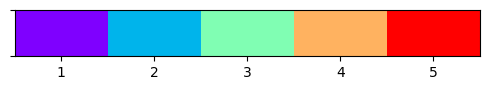

In [5]:
cmap='rainbow'
dict_cluster_to_colors = fu_cluster.create_dict_cluster_to_colours(nb_clusters = 5,
                                                                  cmap=cmap)
fu_cluster.view_colormap(cmap, number_of_colours=5)

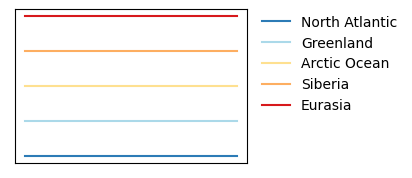

In [18]:
colors=['#a6611a','#dfc27d','#f5f5f5','#80cdc1','#018571']
colors = ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6']
colors = sns.color_palette("colorblind")[:5]

#red #orange #yellow #light blue #dark blue
colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']
clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

fig, ax = plt.subplots(figsize=(3,2))
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, label=names[i])
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.yticks([])
plt.xticks([])

plt.show()

dict_cluster_to_colors = dict(zip(np.arange(1,6,1), colors))

In [9]:
dict_cluster_to_df_mean = {}
for cluster in [1,2,3,4,5]:
    ds_cluster_mean = HYplot.load_df(loadpath=r'E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters',
    filename='df_mean_traj_cluster_'+str(cluster)+'_v2')
    dict_cluster_to_df_mean[cluster] = ds_cluster_mean

loading: E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_1_v2.dat
loading: E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_2_v2.dat
loading: E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_3_v2.dat
loading: E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_4_v2.dat
loading: E:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_5_v2.dat


In [41]:
cluster = 1
ml = 'below_ml'
year = 2003
name = str(year)+str(ml)+'cluster_'+str(cluster)+'.pickle'
loadpath = r'E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot'

ds_cluster = pd.read_pickle(loadpath+'\\'+name)

In [10]:
def concat_dfs(years, cluster = 1, ml = 'below_ml',
               loadpath = r'E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot'):
    DFs = []
    for year in years:
        name = str(year)+str(ml)+'cluster_'+str(cluster)+'.pickle'
        print("load: "+loadpath+'\\'+name)
        ds_cluster = pd.read_pickle(loadpath+'\\'+name)
        DFs.append(ds_cluster)
    ds = pd.concat(DFs, axis=0)
    return ds

## mixed-layer: 

In [67]:
ds_cluster1_ml = concat_dfs(years=np.arange(2002, 2024, 1), cluster=1, ml='below_ml')
ds_cluster2_ml = concat_dfs(years=np.arange(2002, 2024, 1), cluster=2, ml='below_ml')
ds_cluster3_ml = concat_dfs(years=np.arange(2002, 2024, 1), cluster=3, ml='below_ml')
ds_cluster4_ml = concat_dfs(years=np.arange(2002, 2024, 1), cluster=4, ml='below_ml')
ds_cluster5_ml = concat_dfs(years=np.arange(2002, 2024, 1), cluster=5, ml='below_ml')

## full-layer: 

In [11]:
ds_cluster1 = concat_dfs(years=np.arange(2002, 2024, 1), cluster=1, ml='')
ds_cluster2 = concat_dfs(years=np.arange(2002, 2024, 1), cluster=2, ml='')
ds_cluster3 = concat_dfs(years=np.arange(2002, 2024, 1), cluster=3, ml='')
ds_cluster4 = concat_dfs(years=np.arange(2002, 2024, 1), cluster=4, ml='')
ds_cluster5 = concat_dfs(years=np.arange(2002, 2024, 1), cluster=5, ml='')

load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2002cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2003cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2004cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2005cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2006cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2007cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2008cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2009cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2010cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2011cluster_1.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plo

load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2003cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2004cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2005cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2006cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2007cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2008cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2009cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2010cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2011cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plot\2012cluster_5.pickle
load: E:\HYSPLIT\processed\Clustering\years_with_clusters\ready_to_plo

# Plot: 

## individual maps

Empty DataFrame
Columns: [grid_lat, grid_lon, Traj_num]
Index: []
(90, 360)
normalise by sum value: 0.0


C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT_plotting\HYSPLIT_plotting.py:936: RuntimeWarning: invalid value encountered in true_divide
  norm_count_array = count_array/sum_value


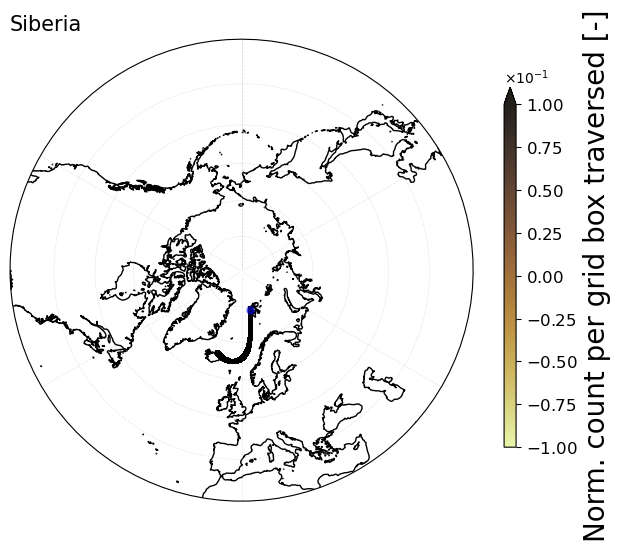

Empty DataFrame
Columns: [grid_lat, grid_lon, Traj_num]
Index: []
(90, 360)
normalise by sum value: 0.0


C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT_plotting\HYSPLIT_plotting.py:936: RuntimeWarning: invalid value encountered in true_divide
  norm_count_array = count_array/sum_value


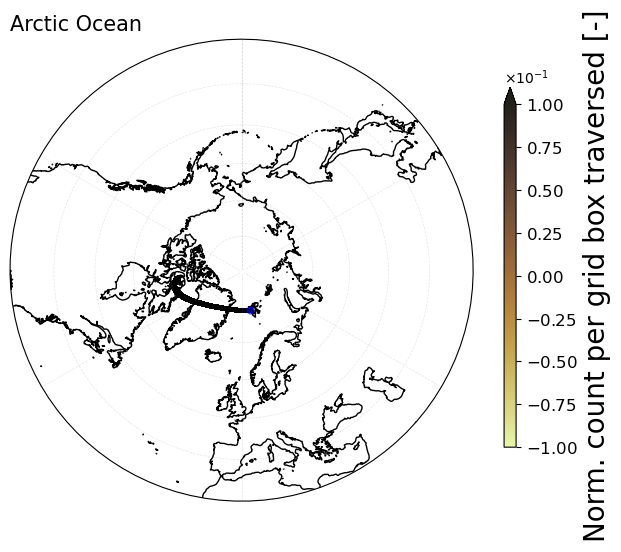

Empty DataFrame
Columns: [grid_lat, grid_lon, Traj_num]
Index: []
(90, 360)
normalise by sum value: 0.0


C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT_plotting\HYSPLIT_plotting.py:936: RuntimeWarning: invalid value encountered in true_divide
  norm_count_array = count_array/sum_value


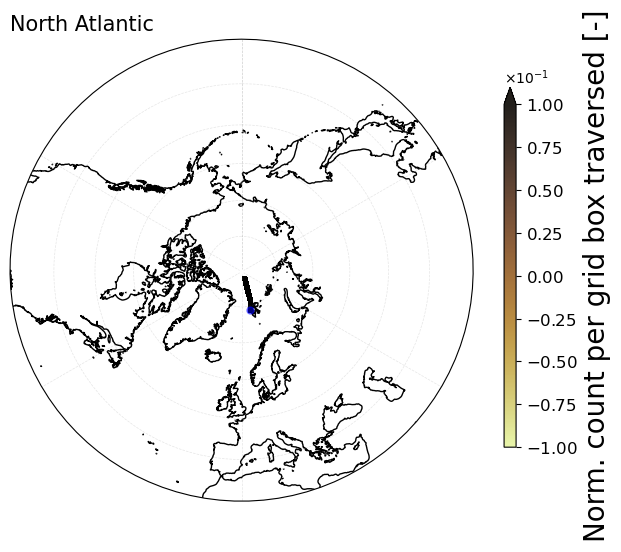

Empty DataFrame
Columns: [grid_lat, grid_lon, Traj_num]
Index: []
(90, 360)
normalise by sum value: 0.0


C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT_plotting\HYSPLIT_plotting.py:936: RuntimeWarning: invalid value encountered in true_divide
  norm_count_array = count_array/sum_value


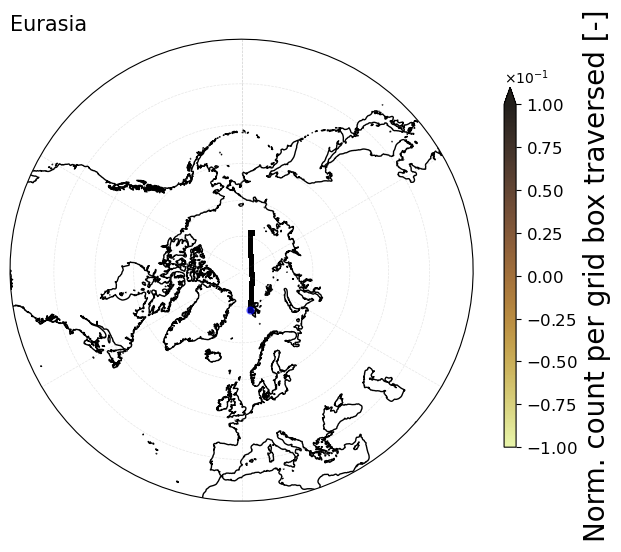

       grid_lat  grid_lon  Traj_num
0            28       110        11
1            28       111         2
2            29       110         4
3            29       111         7
4            29       118         5
...         ...       ...       ...
15014        89       356      9248
15015        89       357      9234
15016        89       358      9593
15017        89       359      9935
15018        90       198    631666

[15019 rows x 3 columns]
(90, 360)
normalise by sum value: 152163845.0


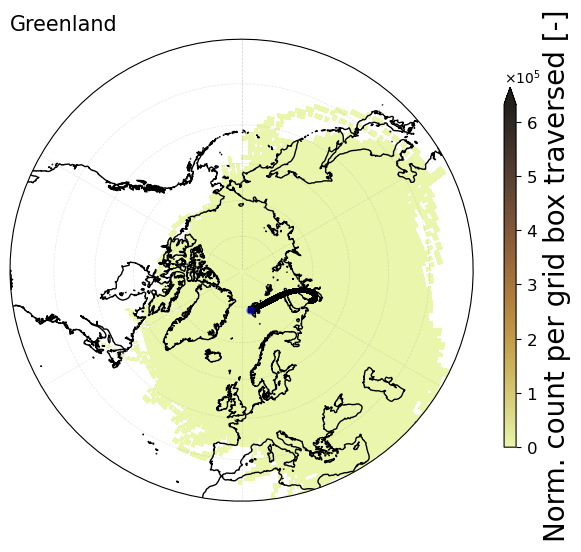

In [24]:
savepath=inpath_processed_hysplit_dfs+'Clustering\\cluster_arrays\\full_layer\\'
#savepath=inpath_processed_hysplit_dfs+'Clustering\\cluster_arrays\\mixed_layer\\'

for cluster, title in zip([1,2,3,4,5], ['Siberia', 'Arctic Ocean', 'North Atlantic', 'Eurasia', 'Greenland']):
    fig = HYplot.plot_clusters(ds_cluster5, cluster=cluster, title=title, vmax=None, 
                               savepath=savepath, dict_cluster_to_df_mean=dict_cluster_to_df_mean, 
                               threshold=0)

       grid_lat  grid_lon  Traj_num
0            28       110         2
1            28       111         2
2            29       111         7
3            30       111         3
4            31       112         1
...         ...       ...       ...
12706        89       356      4588
12707        89       357      4543
12708        89       358      4675
12709        89       359      4704
12710        90       198    442495

[12711 rows x 3 columns]
(90, 360)
normalise by sum value: 45254736.0


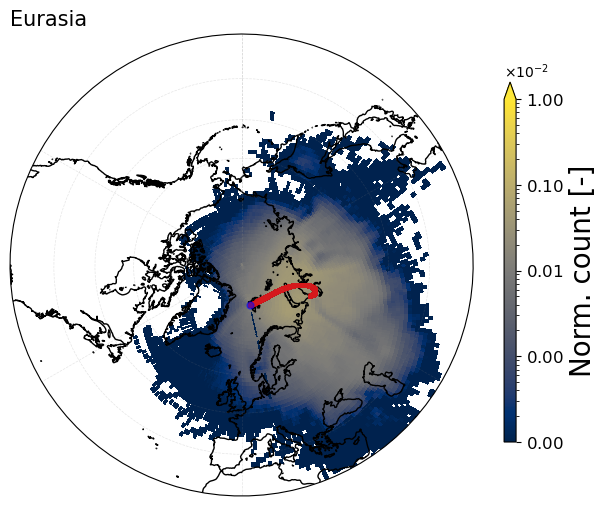

In [100]:
dict_cluster_to_title = dict(zip([1,2,3,4,5], ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']))
cluster = 5

title = dict_cluster_to_title[5]
savepath=inpath_processed_hysplit_dfs+'Clustering\\cluster_arrays\\'
savepath=inpath_processed_hysplit_dfs+'Clustering\\cluster_arrays\\full_layer\\'

fig = HYplot.plot_clusters(ds_cluster5, cluster=cluster, title=title, vmax=5*10**(-4), 
                           savepath=savepath, dict_cluster_to_df_mean=dict_cluster_to_df_mean, 
                           threshold=0, cmap='cividis', scientific_notation=True, 
                           colourbar_label="Norm. count [-]", dict_cluster_to_colors=dict_cluster_to_colors,
                           plot_log=True, vminlog=10**(-6), vmaxlog=10**(-2))

       grid_lat  grid_lon  Traj_num
0            21       239         1
1            23       244         2
2            24       244         3
3            24       278         5
4            24       279         6
...         ...       ...       ...
14820        89       356      6439
14821        89       357      6429
14822        89       358      6241
14823        89       359      6138
14824        90       198    224854

[14825 rows x 3 columns]
(90, 360)


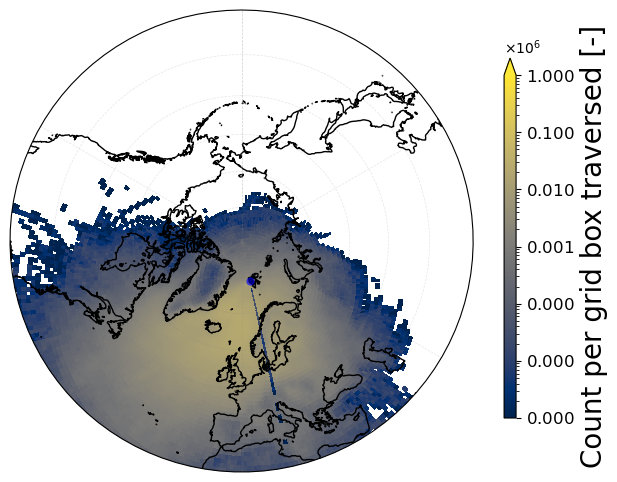

In [91]:
cluster = 1
df_cluster = ds_cluster1_ml[ds_cluster1_ml['clusters_5'] == cluster].copy()   
df_threshold = HYplot.groupby_lat_lon(df_cluster, type_of_function_obs=np.count_nonzero,
                               threshold=0)
print(df_threshold)
count_array = HYplot.create_count_array(df_threshold) 
fig = HYplot.circular_plots_array(count_array, vmax=None, cmap='cividis', 
                   orientation='vertical', colourbar_label=r"Count per grid box traversed [-]", 
                   colourbar_labelsize=20, colourbar_tick_fontsize=12, decimal_places_colourbar=2, 
                   scientific_notation=True, axes_projection='North_Stereo', array_projection='rotated_pole', 
                   title='', plot_log=True, vminlog=10**(0), vmaxlog=10**(6))

## As subplots: 

In [25]:
loadpath_mean_trajs = 'C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Clustering\\ensembles_for_clustering\\xyz_rotated\\mean_trajs_clusters'
loadpath_cluster_arrays = 'C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Clustering\\cluster_arrays\\full_layer\\'

In [27]:
clusters = np.arange(1, 6, 1)
clusters_arrays = HYplot.load_year_arrays(clusters, 
                                          path=loadpath_cluster_arrays)

1
2
3
4
5


In [28]:
dict_cluster_to_df_mean = {}
for cluster in [1,2,3,4,5]:
    ds_cluster_mean = HYplot.load_df(loadpath=loadpath_mean_trajs,
    filename='df_mean_traj_cluster_'+str(cluster))
    dict_cluster_to_df_mean[cluster] = ds_cluster_mean

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_1.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_2.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_3.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_4.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_5.dat


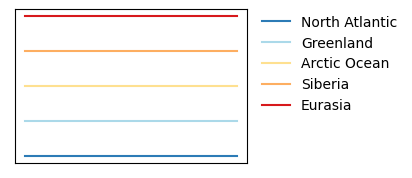

In [31]:
colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']
clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

fig, ax = plt.subplots(figsize=(3,2))
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, label=names[i])
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.yticks([])
plt.xticks([])

plt.show()

dict_cluster_to_colors = dict(zip(np.arange(1,6,1), colors))

# Figure 4: 

num years: 5
num cols: 5
number of rows: 1
{'North Atlantic': 1, 'Greenland': 2, 'Arctic Ocean': 3, 'Siberia': 4, 'Eurasia': 5}
1
{1: 'North Atlantic', 2: 'Greenland', 3: 'Arctic Ocean', 4: 'Siberia', 5: 'Eurasia'}
0
2
{1: 'North Atlantic', 2: 'Greenland', 3: 'Arctic Ocean', 4: 'Siberia', 5: 'Eurasia'}
1
3
{1: 'North Atlantic', 2: 'Greenland', 3: 'Arctic Ocean', 4: 'Siberia', 5: 'Eurasia'}
2
4
{1: 'North Atlantic', 2: 'Greenland', 3: 'Arctic Ocean', 4: 'Siberia', 5: 'Eurasia'}
3
5
{1: 'North Atlantic', 2: 'Greenland', 3: 'Arctic Ocean', 4: 'Siberia', 5: 'Eurasia'}
4


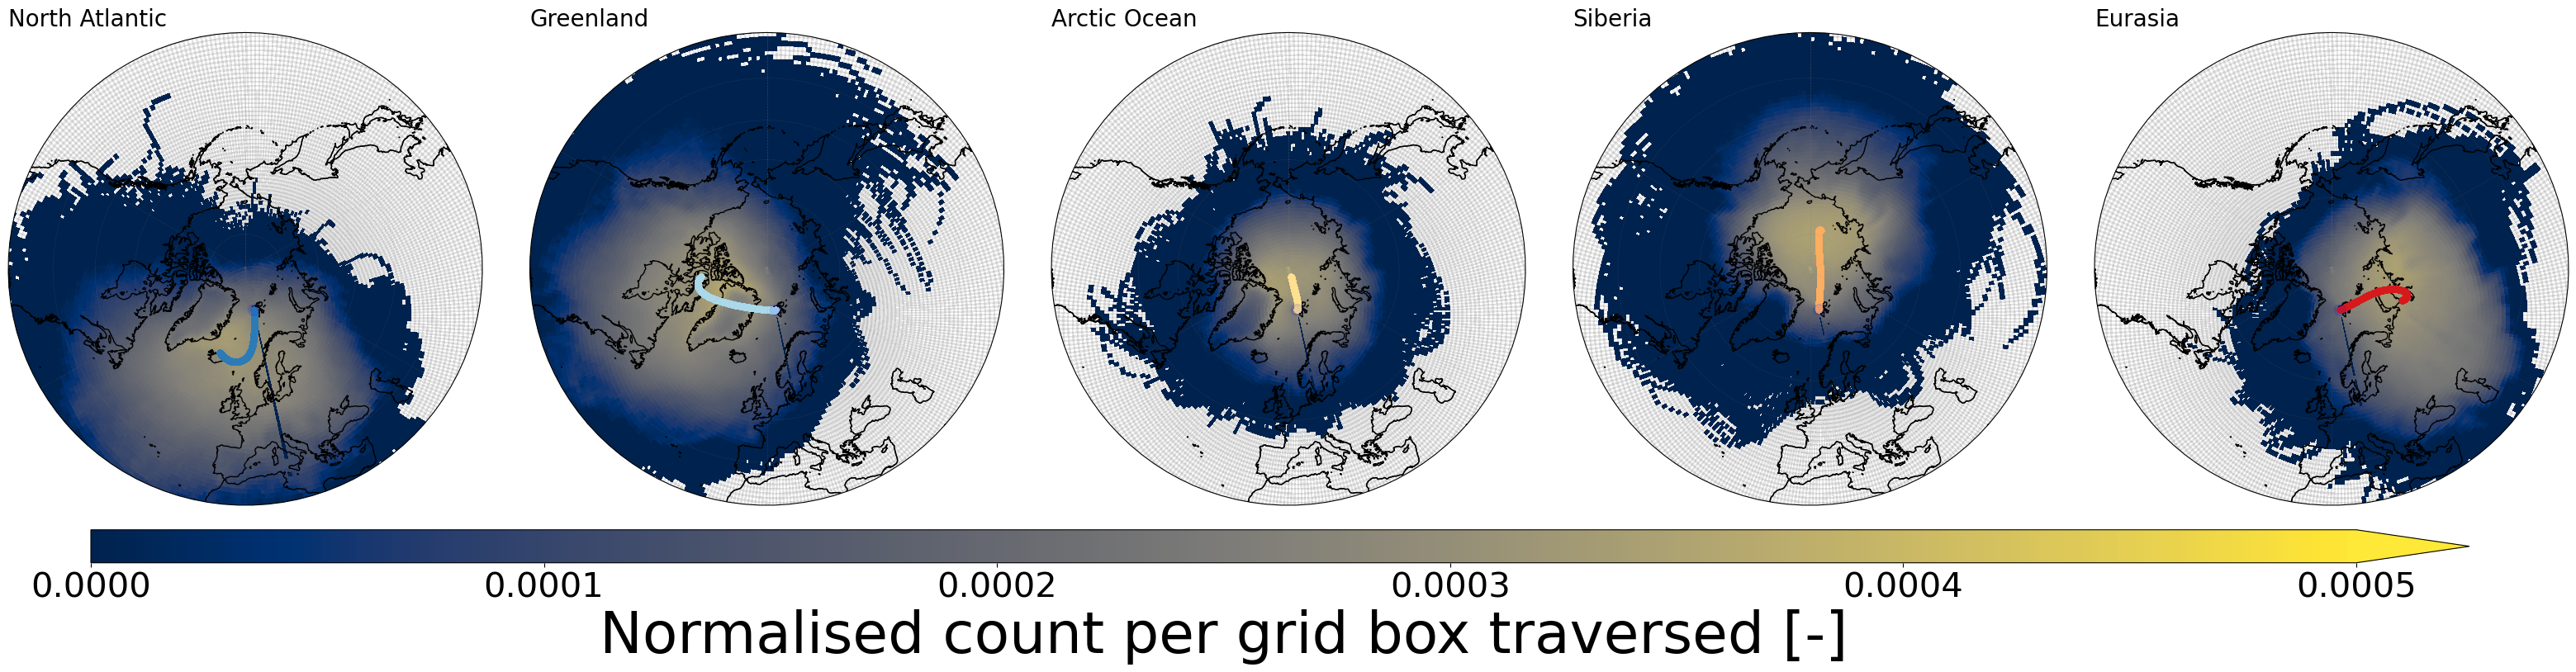

In [30]:
clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']

dict_cluster_to_colors = dict(zip(np.arange(1,6,1), colors))

fig = HYplot.array_subplots(clusters_arrays, years=np.arange(1, 6, 1), nrows=1, vmax=5*10**(-4), start_year=1,
               colourbar_label=r"Normalised count per grid box traversed [-]", 
               suptitle='', axes_projection='North_Stereo',  dict_titles=dict_titles,
               array_projection='rotated_pole', delete_axes=None, cb_height=0.05, scientific_notation=False,
               decimal_places_colourbar=3, cmap='cividis',
               dict_cluster_to_df_mean=dict_cluster_to_df_mean,
               dict_cluster_to_colors=dict_cluster_to_colors, s=20, alpha=1, plot_log=True, 
               vminlog=10**(-6), vmaxlog=10**(-2))
HYplot.save_plot(fig, savepath_plots, name='Figure4', formate=".png", dpi=300)

### Reorder: 

5
4
2
3
1
0
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_5.dat
1
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_4.dat
2
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_2.dat
3
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_3.dat
4
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_1.dat
num years: 5
num cols: 5
number of rows: 1
{'North Atlantic': 5, 'Greenland': 4, 'Arctic Ocean': 2, 'Siberia': 3, 'Eurasia': 1}
1
{5: 'North Atlantic', 4: 'Greenland', 2: 'Arctic Ocean'

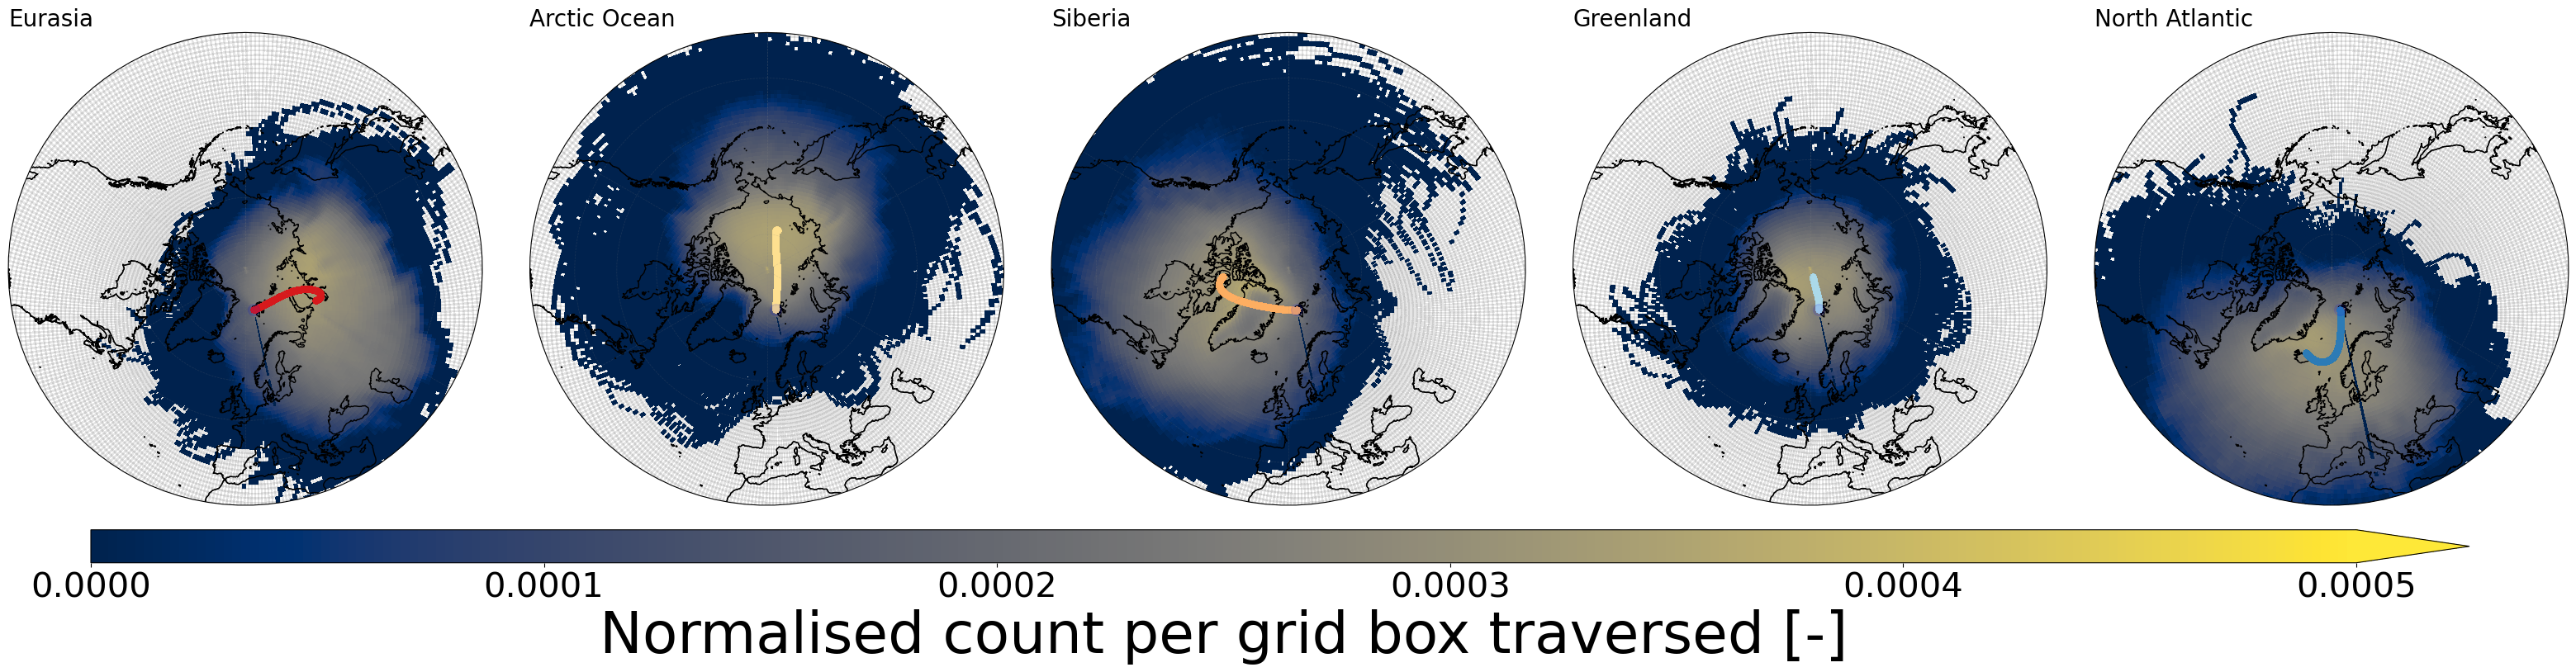

In [24]:
clusters = [5,4,2,3,1]
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))
colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']

dict_cluster_to_colors = dict(zip(clusters, colors))

clusters = [5,4,2,3,1]
clusters_arrays = HYplot.load_year_arrays(clusters, 
                                          path=loadpath_cluster_arrays)

dict_cluster_to_df_mean = {}
for i, cluster in enumerate([5,4,2,3,1]):
    print(i)
    ds_cluster_mean = HYplot.load_df(loadpath=loadpath_mean_trajs,
    filename='df_mean_traj_cluster_'+str(cluster))
    dict_cluster_to_df_mean[i+1] = ds_cluster_mean

fig = HYplot.array_subplots(clusters_arrays, years=[1,2,3,4,5], nrows=1, vmax=5*10**(-4), start_year=1,
               colourbar_label=r"Normalised count per grid box traversed [-]", 
               suptitle='', axes_projection='North_Stereo',  dict_titles=dict_titles,
               array_projection='rotated_pole', delete_axes=None, cb_height=0.05, scientific_notation=False,
               decimal_places_colourbar=3, cmap='cividis',
               dict_cluster_to_df_mean=dict_cluster_to_df_mean,
               dict_cluster_to_colors=dict_cluster_to_colors, s=20, alpha=1, plot_log=True, 
               vminlog=10**(-6), vmaxlog=10**(-2))